In [116]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns

import argparse
import random
import networkx as nx

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from ignite.engine import Engine, Events
#from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

method = ''
from g2g_model_Fisher import *

## **Data overview** ##

In [117]:
data_path = 'data/'
data_name = 'EG_bin_ppt'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
# data_name = 'zebrafish_dynamo_part'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
pca_dim = 50
[k_nei, K, L] = [10, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

result_path = 'action_results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = result_path
cmap = plt.colormaps['Spectral']

In [118]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

folder = os.path.exists(figure_path)
if not folder:
    os.makedirs(figure_path)

In [119]:
from scipy.sparse import csr_matrix
import scanpy as sc
adata = adata0.copy()
sc.pp.pca(adata, n_comps=pca_dim)
sc.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=pca_dim, n_neighbors=k_nei)
scv.tl.velocity(adata)

gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
Xs = adata.layers['Ms'] #adata.X.A#
# Xs = adata.layers['M_s'] #如果是EG_ab_dyn
X = Xs

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc=np.amax(adata.obsp['distances'])
cell_nei=adata.obsp['distances'].indices.reshape([-1,k_nei-1])
nei_w=[]
rho_arr=[]
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)


#################################################
#################################################
encoder = torch.load(result_path+'encoder.pt')


mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

Fisher_g_diag = np.zeros([X.shape[0],L*2])
for i in range(X.shape[0]):
    Fisher_g_diag[i] = np.diag(Fisher_g[i])

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2+1e-12)
    return W_dist

cRc_arr=[]
cRc_arr_eu=[]
A = csr_matrix(A_mat + np.eye(A_mat.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [120]:
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
velo_pca = velo_g@adata.varm['PCs']
latent_z = np.hstack((mu_learned,sigma_learned))

In [121]:
X_plt = -X_pca[:,0]
Y_plt = -X_pca[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min-wid*10
Y_ori = Y_min-wid*10

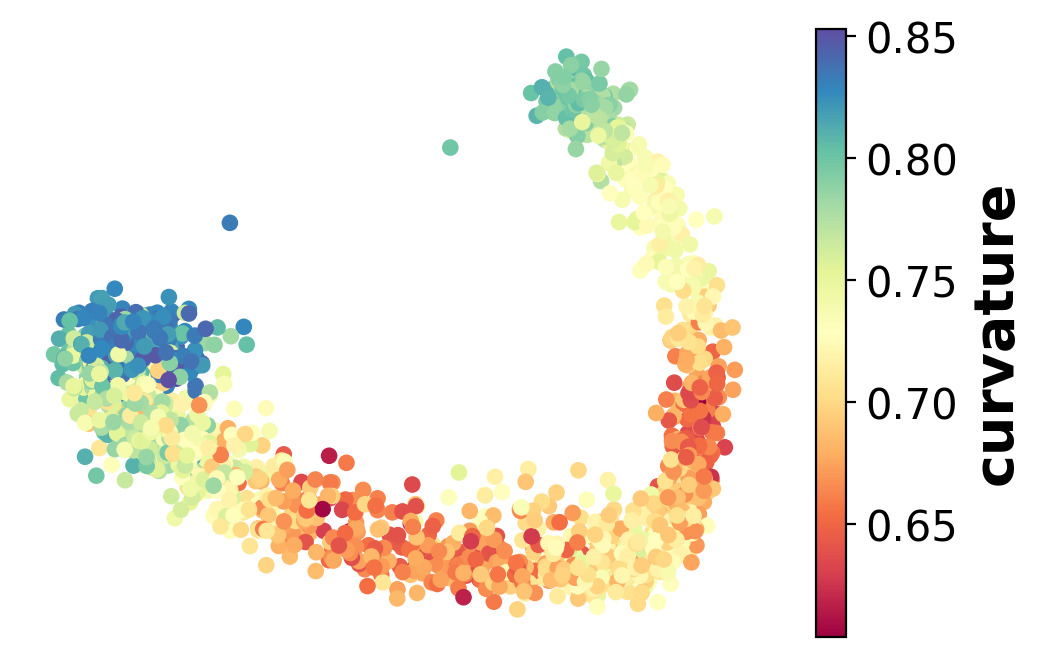

In [122]:
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
plt.axis('off')
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

## **Average Path** ##

In [123]:
G = nx.from_scipy_sparse_array(A_mat)
for i in np.array(G.edges):
    G.edges[i]['dist_fisher'] = Fisher_distz(latent_z[i[0]],latent_z[i[1]])
    G.edges[i]['dist_euclidean'] = np.linalg.norm(X_pca[i[0],:]-X_pca[i[1],:])
    G.edges[i]['weight'] = (latent_z[i[1]]-latent_z[i[0]]).T@Fisher_g[i[0]]@(latent_z[i[1]]-latent_z[i[0]])
    # G.edges[i]['weight'] = np.sqrt((latent_z[i[1]]-latent_z[i[0]]).T@(latent_z[i[1]]-latent_z[i[0]]))

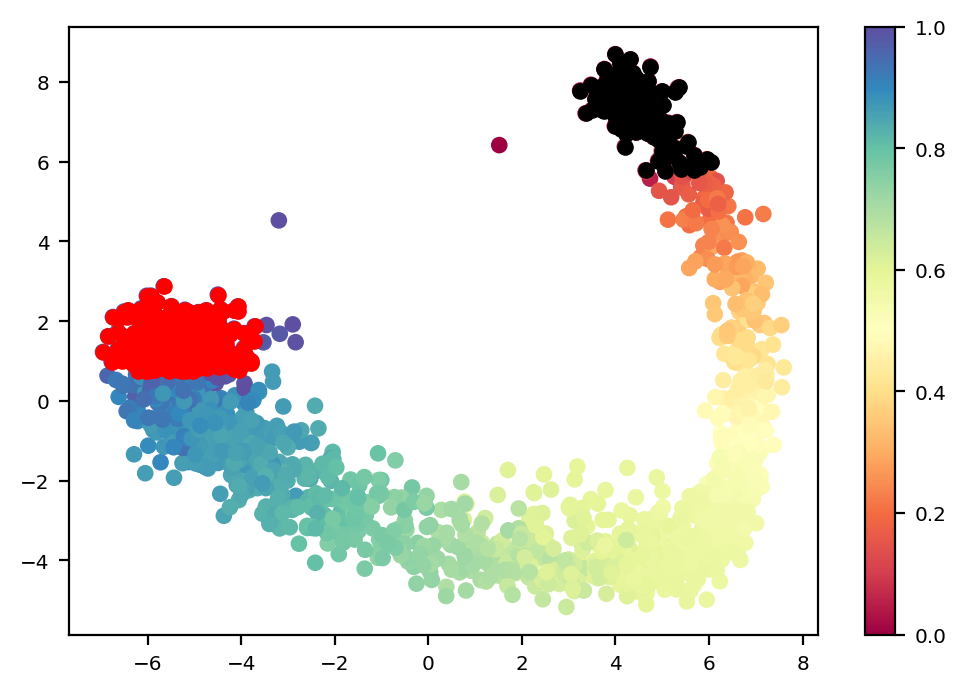

In [124]:
# sample paths from black to red
cell_vpt = adata.obs['palantir_pseudotime']
left_top_indices = np.where((X_plt[:] < np.quantile(X_plt[:], 0.4)) * (Y_plt[:] > np.quantile(Y_plt[:], 0.6)))[0] #Ends
right_top_indices = np.where((X_plt[:] > np.quantile(X_plt[:], 0.6)) * (Y_plt[:] > np.quantile(Y_plt[:], 0.9)))[0] #Starts
plt.scatter(X_plt[idx],Y_plt[idx],c=cell_vpt,s=30,cmap=cmap)
plt.colorbar() # Color is pseudotime
plt.scatter(X_plt[left_top_indices],Y_plt[left_top_indices],c='red',s=30,cmap=cmap)
plt.scatter(X_plt[right_top_indices],Y_plt[right_top_indices],c='black',s=30,cmap=cmap)

In [125]:
# Least length path
sources = right_top_indices
targets = left_top_indices
paths = [nx.shortest_path(G,source=sources[i],target=targets[i],weight='weight') for i in range(min(len(sources),len(targets)))]

# Nodes indices to coordinates
maxlen = 0
for k in range(len(paths)):
    maxlen = max(len(paths[k]),maxlen)

for k in range(len(paths)):
    while len(paths[k])<maxlen:
        paths[k].append(paths[k][-1])

paths_pca = np.zeros([len(paths),maxlen,X_pca.shape[1]])
for k in range(len(paths)):
    paths_pca[k] = X_pca[np.array(paths[k])]

# DTW barycenter averaging
from tslearn.barycenters import dtw_barycenter_averaging
average_path = dtw_barycenter_averaging(np.array(paths_pca))

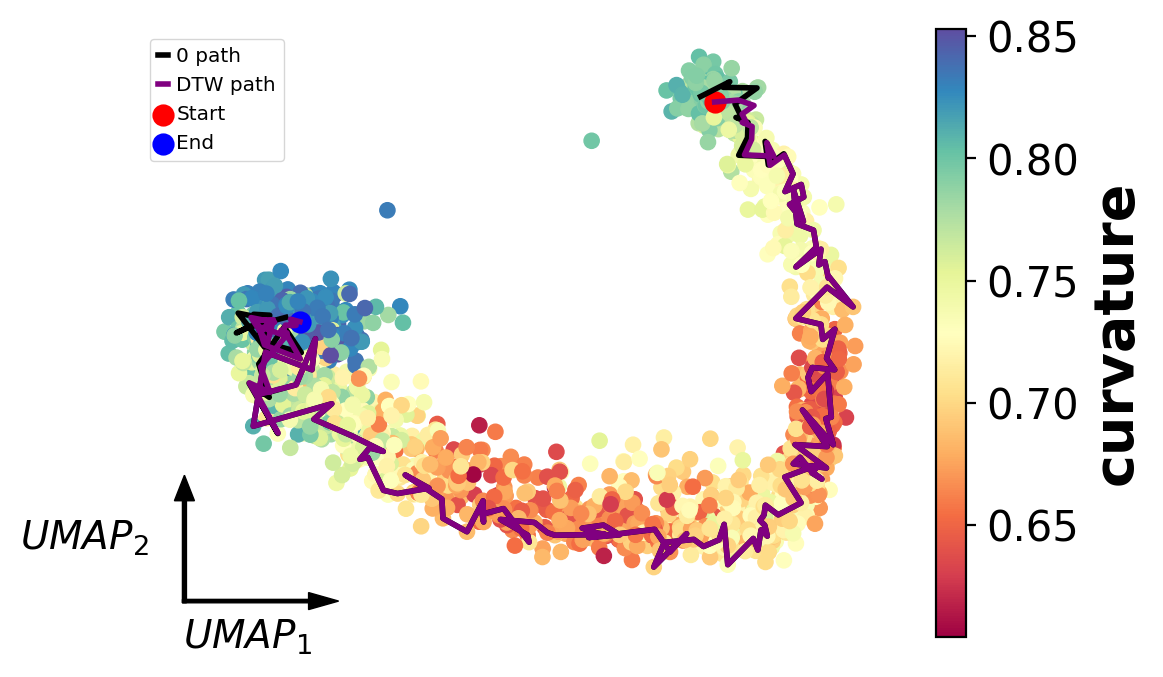

In [126]:
# Plotting the average path
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')
plt.axis('off')
plt.plot(X_plt[paths[0]],Y_plt[paths[0]],c='black', linewidth=2, label='0 path')
plt.plot(-average_path[:,0],-average_path[:,1],c='purple', linewidth=2, label='DTW path')
plt.scatter(-average_path[0,0],-average_path[0,1],c='red', linewidth=2, label='Start')
plt.scatter(-average_path[-1,0],-average_path[-1,1],c='blue', linewidth=2, label='End')
# plt.scatter(X_plt[average_path[0]],Y_plt[average_path[0]], color='red', s=50, label='Start')
# plt.scatter(X_plt[average_path[-1]],Y_plt[average_path[-1]], color='blue', s=50, label='End')
plt.legend(loc = 'best')



plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*25,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')

plt.savefig(result_path+'path.png')

In [127]:
# trans coordinates in average_path to nodes indices
distances = np.linalg.norm(X_pca[:, np.newaxis,:] - average_path, axis=2)

nearest_indices = np.argmin(distances, axis=0)

## **Plot the FI and Velo along the path** ##

In [128]:
#------use a simple neural network to study dmu/dt and dsigma/dt
latent_z = np.hstack((mu_learned,sigma_learned))
pca_dim = 50


model = nn.Sequential(
    nn.Linear(pca_dim, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=1e-3)

x_in=torch.tensor(X_pca.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(200):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
#     if epoch% 10 == 9:
#         print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

pZ_pX = np.zeros([X.shape[0], L*2, X_pca.shape[1]])

# Compute the gradients
for i in range(X.shape[0]):
    x0=torch.tensor(X_pca[i,:],requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX[i,j,:] = x0.grad.detach()
        
Fisher_pca = np.zeros((X.shape[0],pca_dim, pca_dim))
for i in range(X.shape[0]):
    Fisher_pca[i] = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]

Z_velo = np.array([pZ_pX[i]@velo_pca[i] for i in range(X.shape[0])])

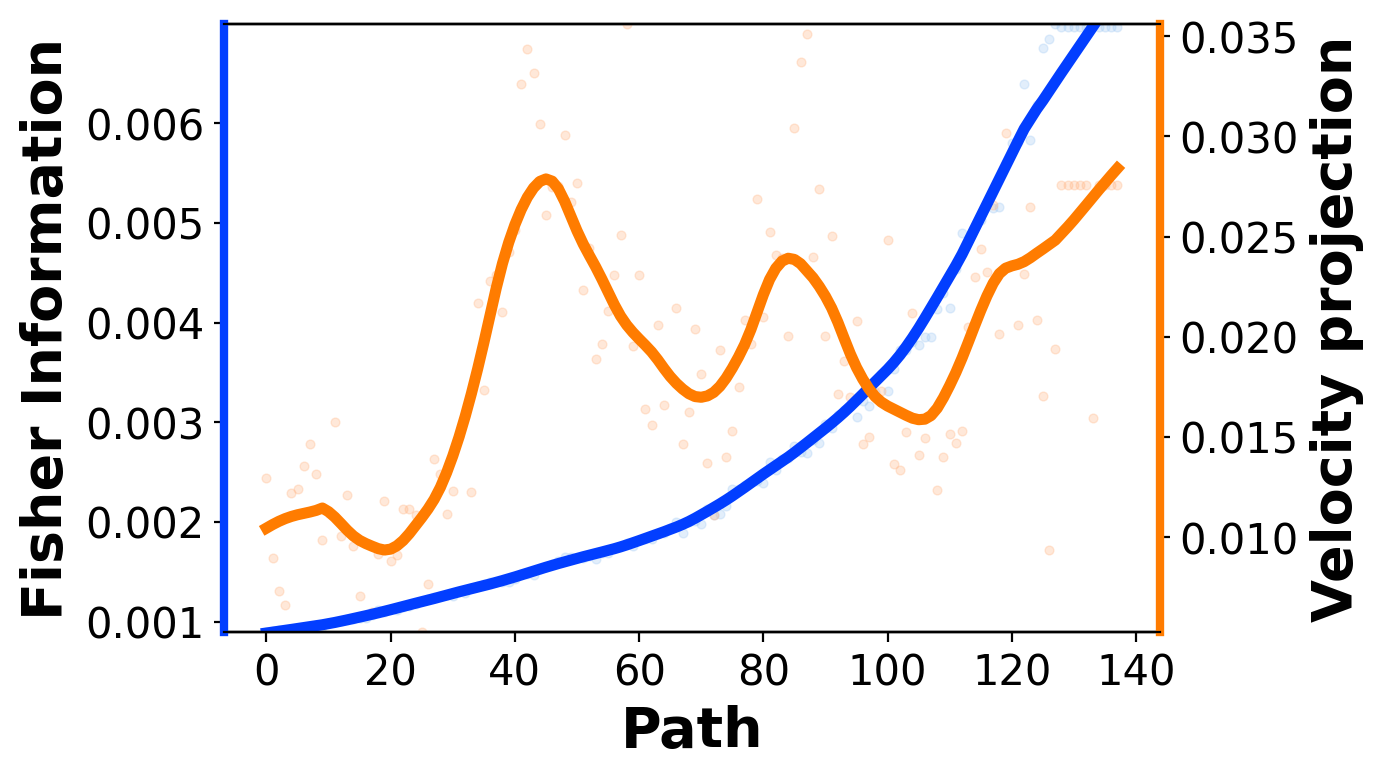

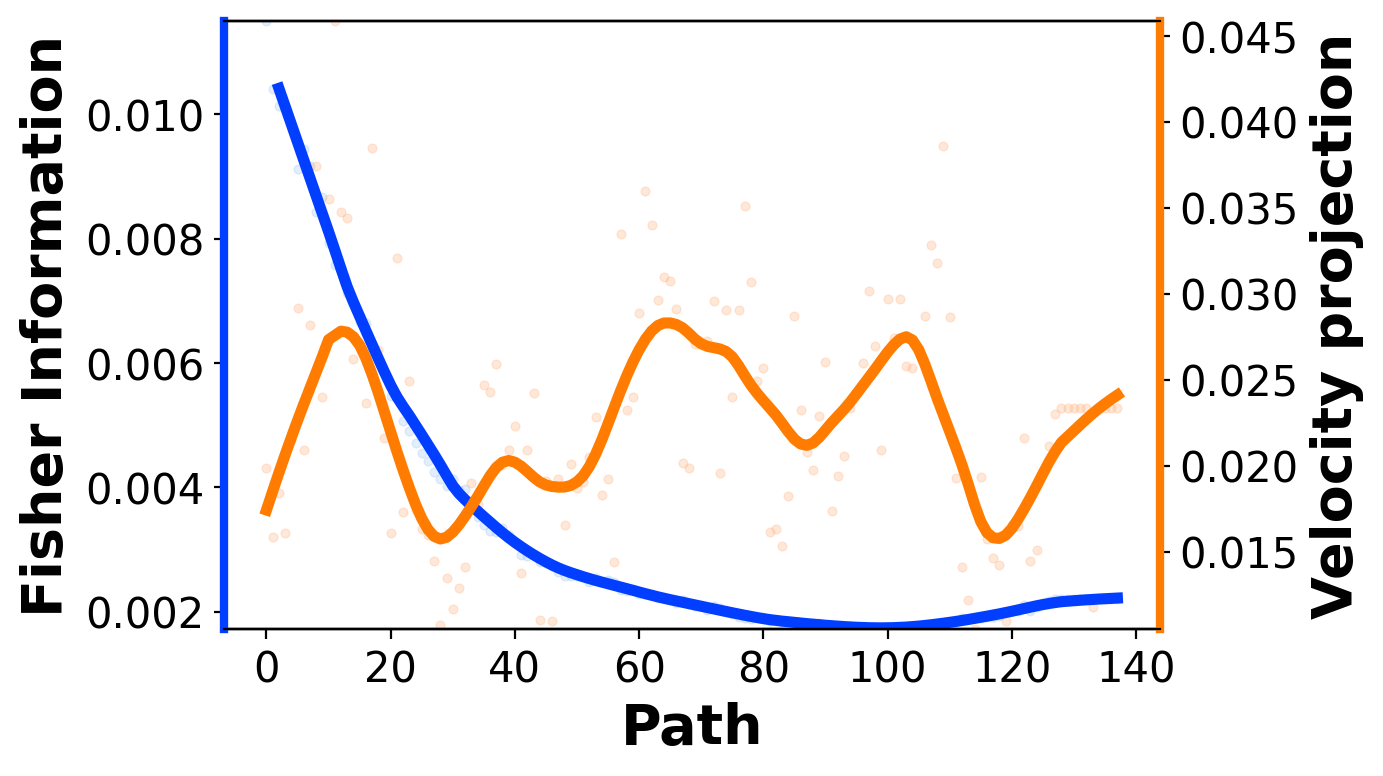

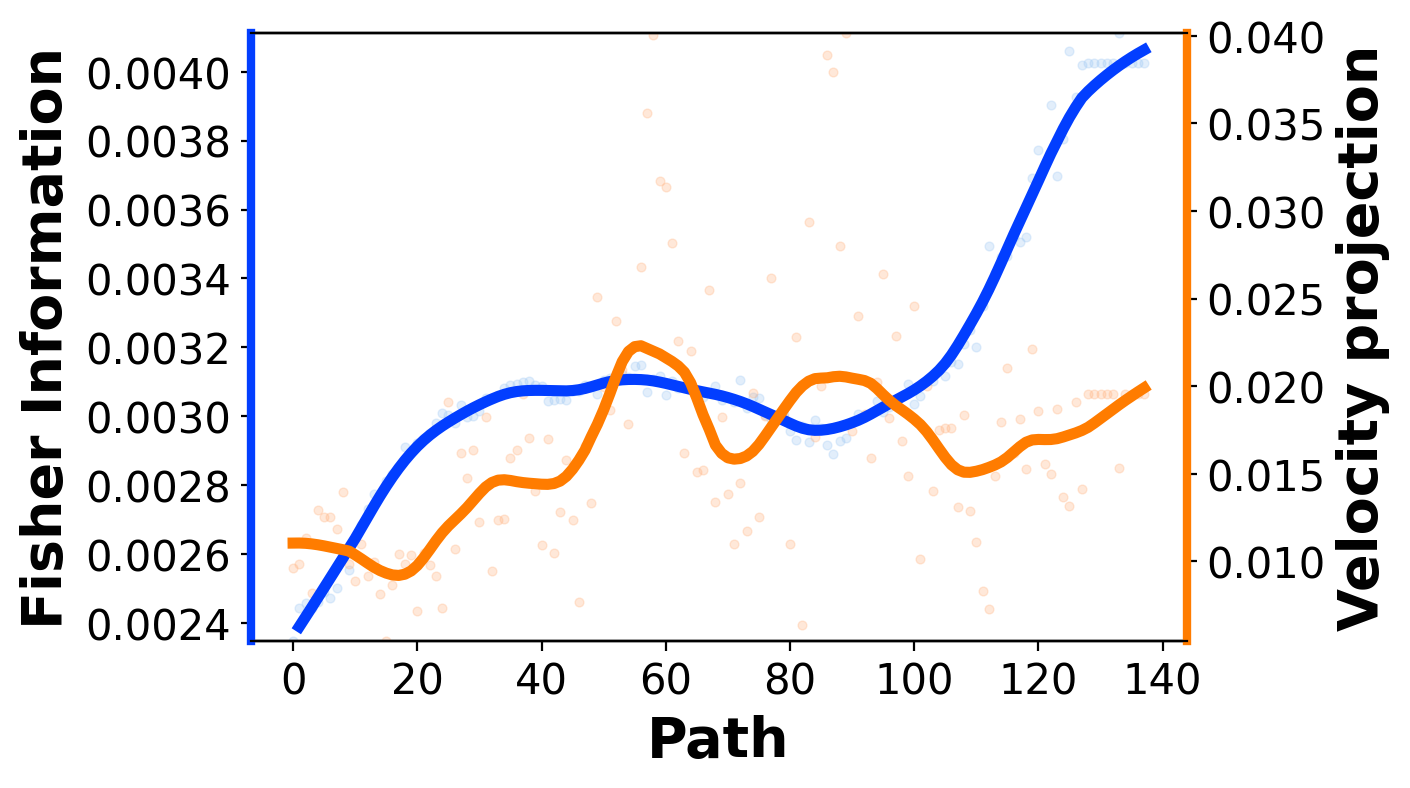

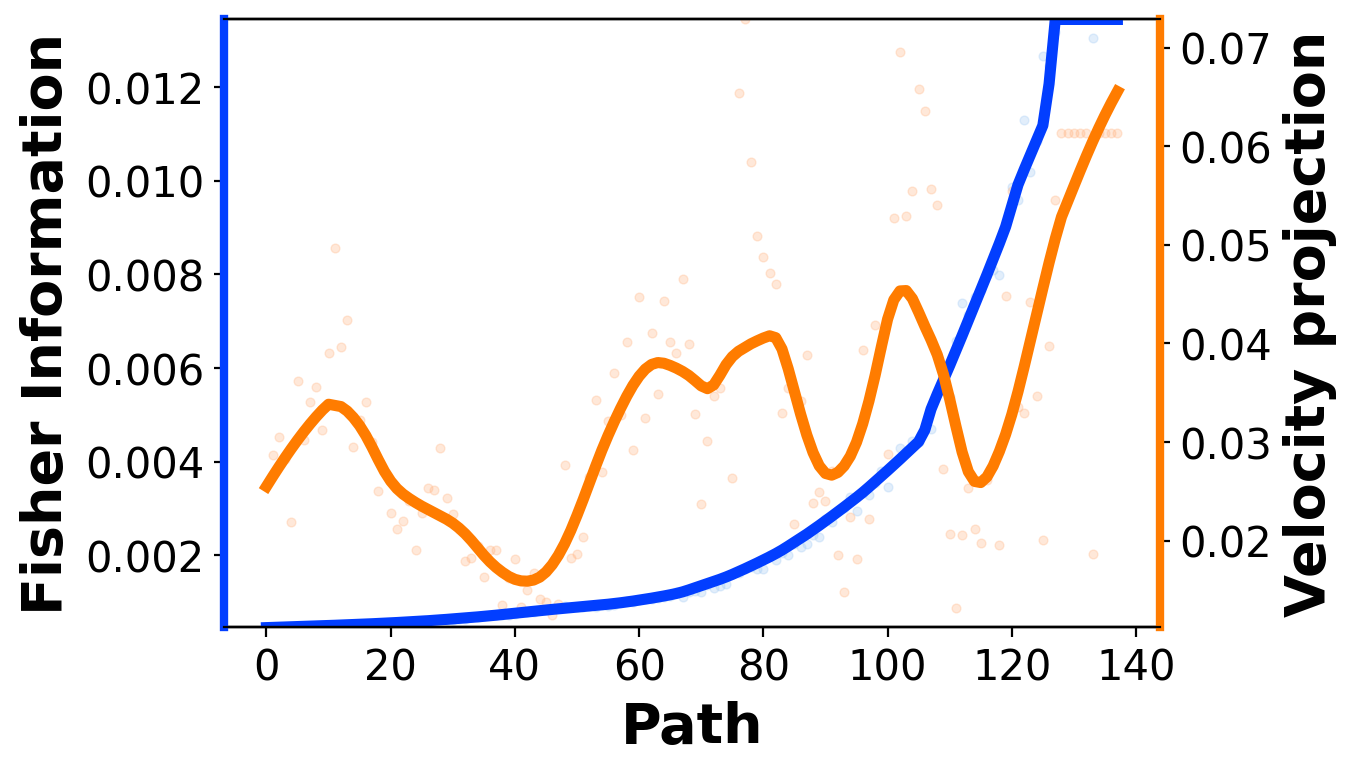

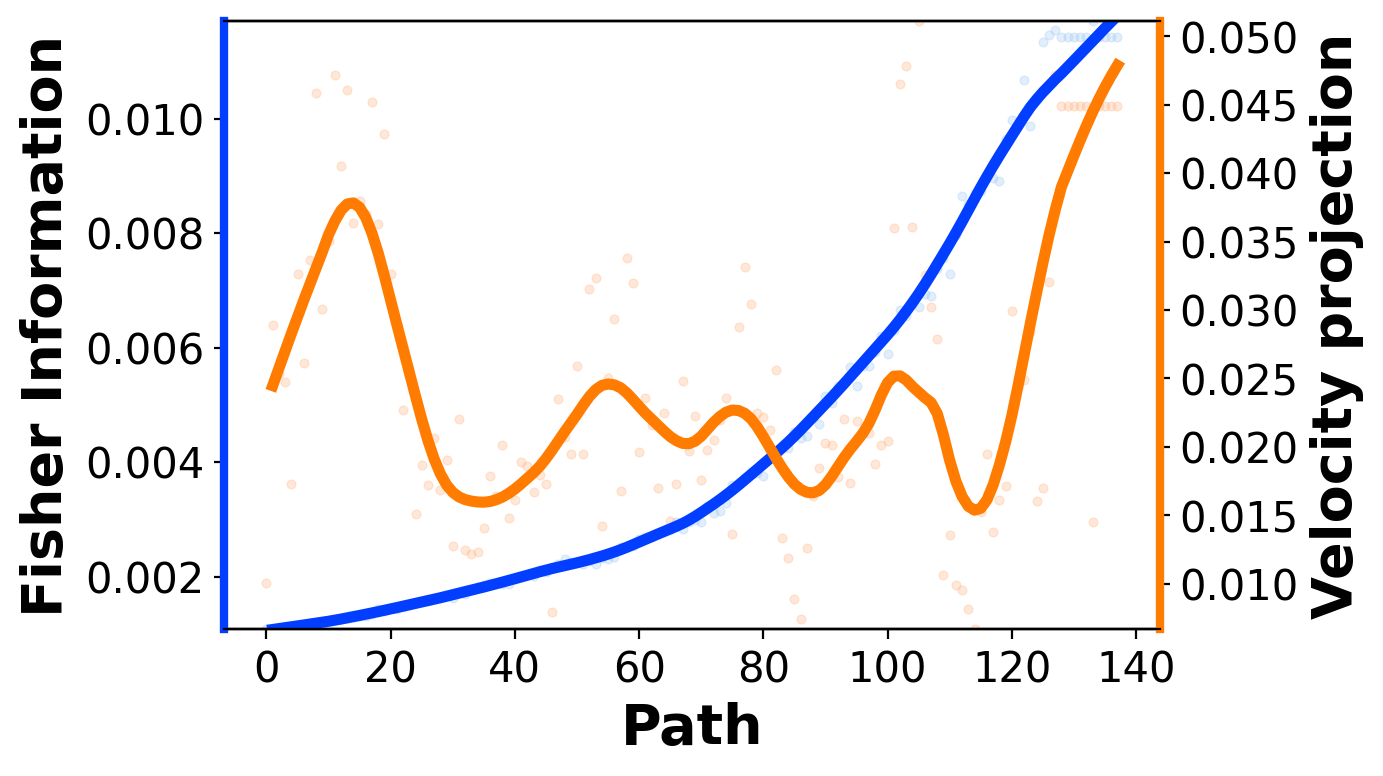

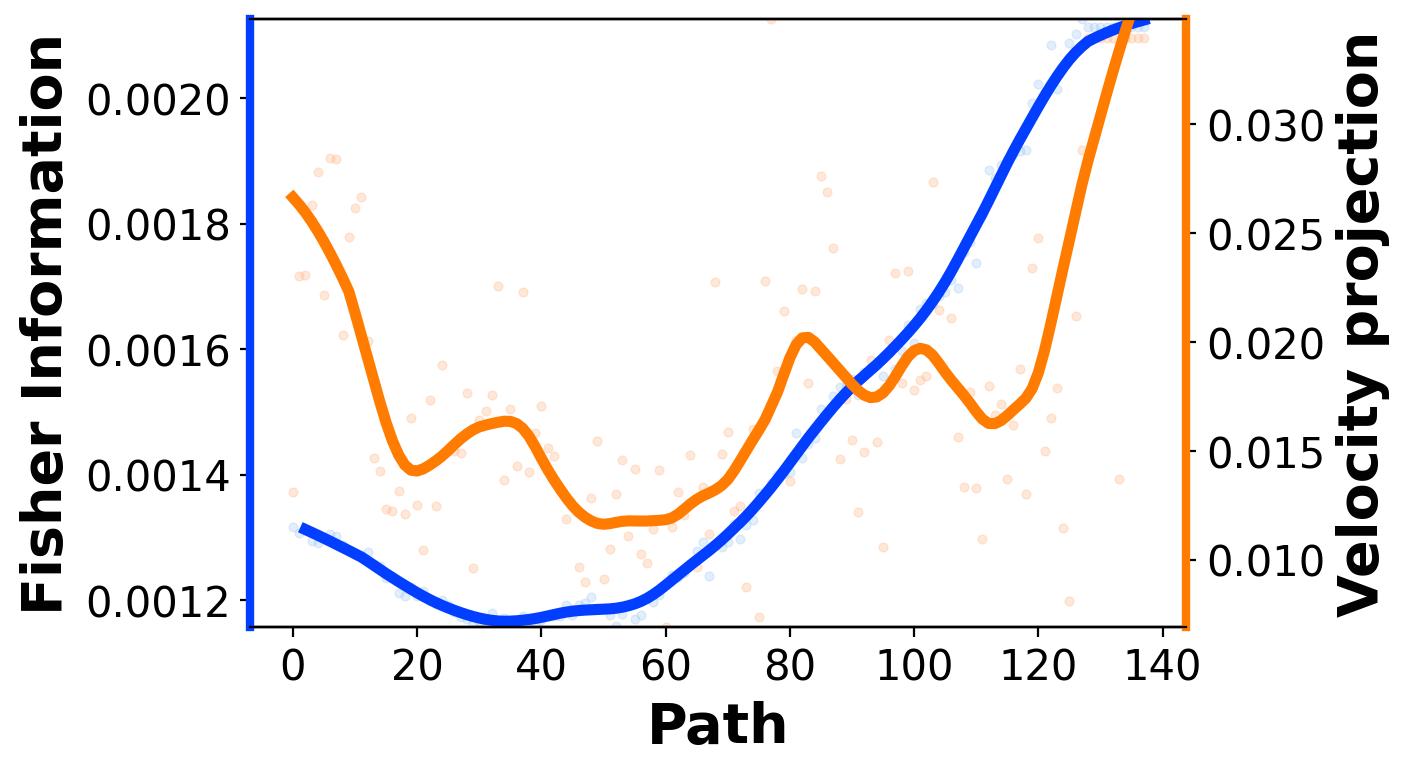

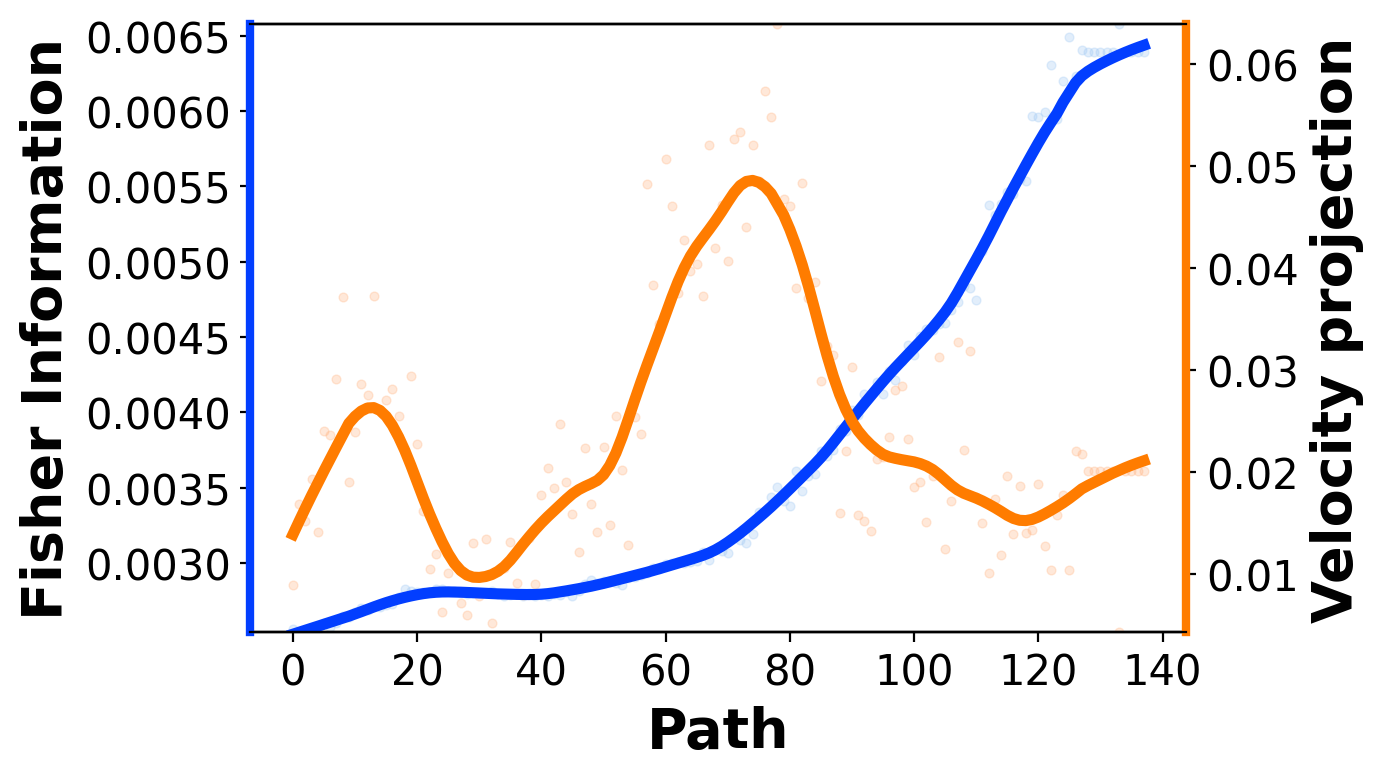

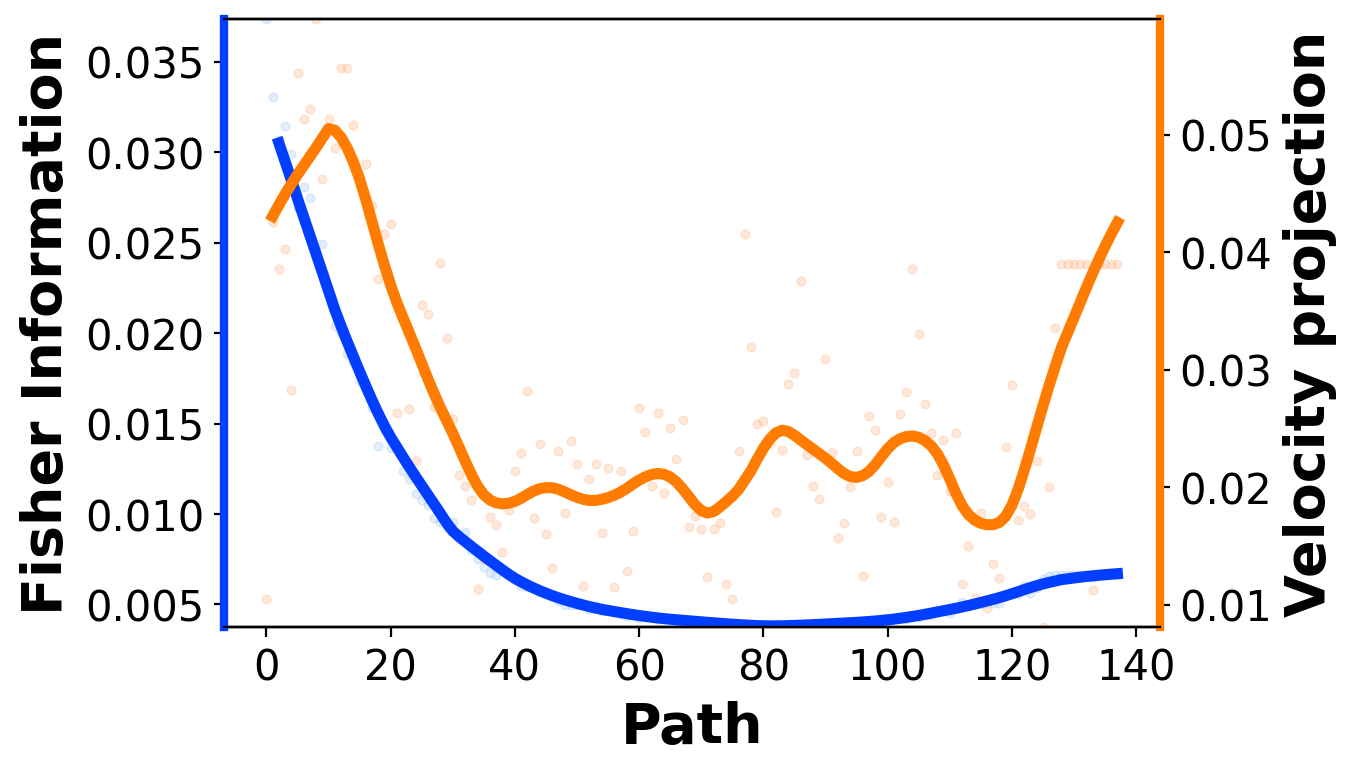

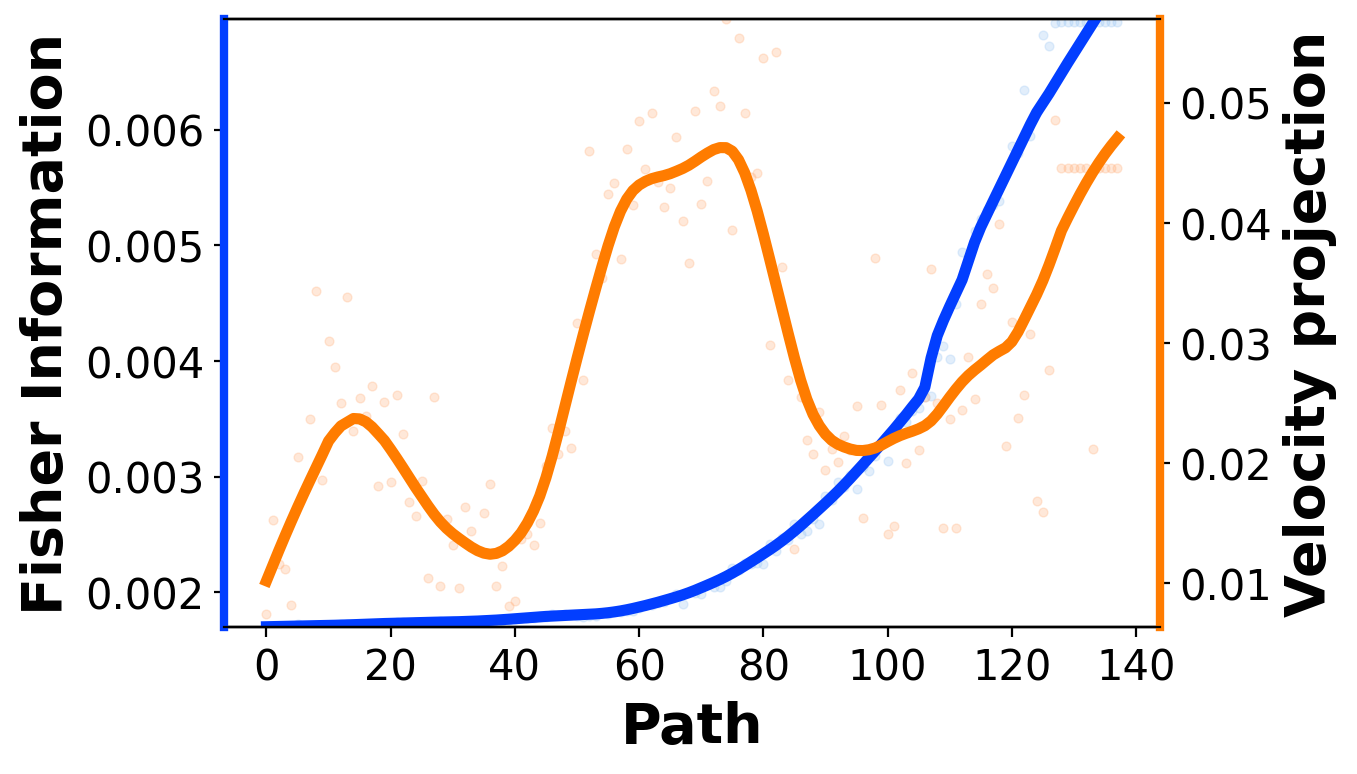

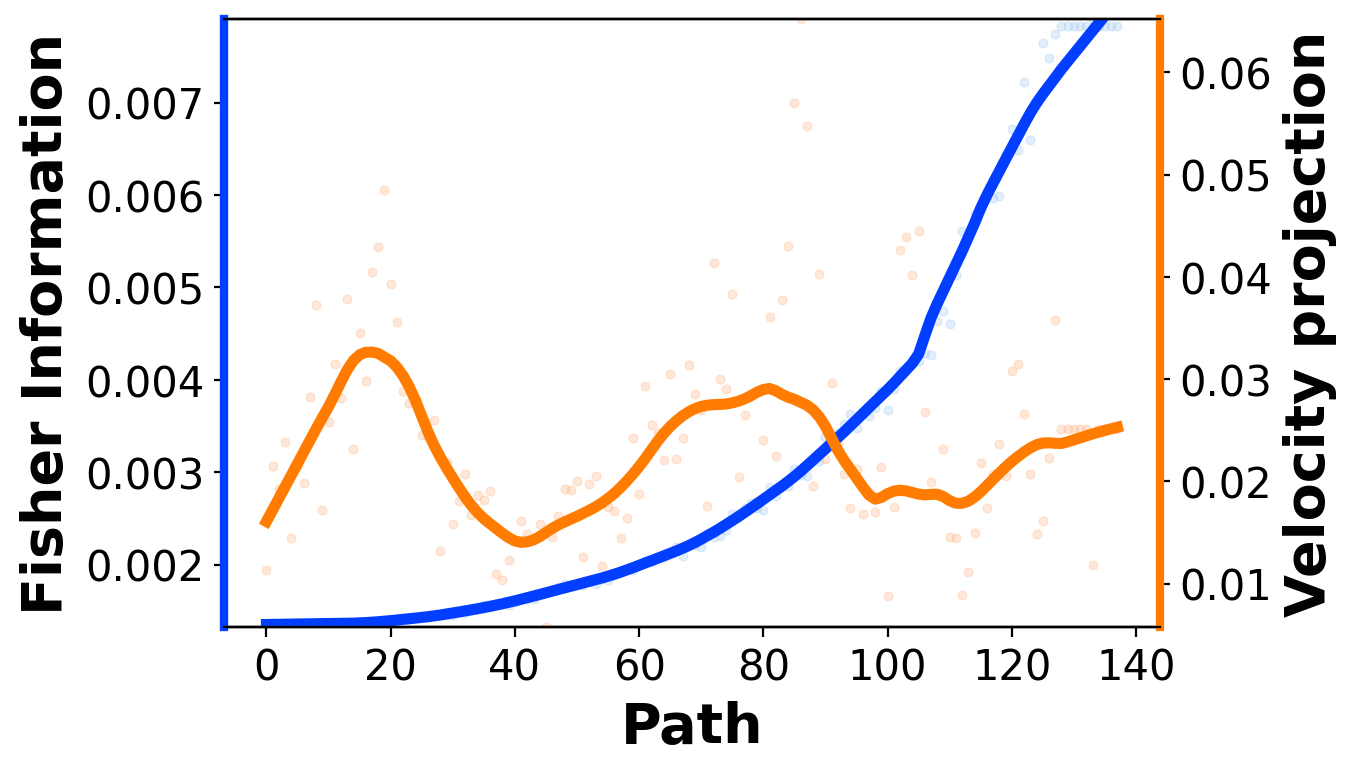

In [129]:
alpha = 0.3
frac = 0.15
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)
velo_pro = Z_velo

# for i in range(hs_dim):
#     plt.scatter(cell_vpt[:],smooth_func(Fisher_hs[:,i,i]),s=30)
#     plt.scatter(cell_vpt[:],smooth_func(np.abs(velo_pro[:,-(i+1)])),s=30)
    
#     plt.show()


for i in range(L):
# plt.figure(dpi=600,bbox_inches='tight')
    mask1,x_ls1,y_ls1 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(Fisher_g[:,i,i])[nearest_indices],frac=frac)
    plt.scatter(range(nearest_indices.shape[0]), smooth_func(Fisher_g[:,i,i])[nearest_indices],c=palette2[0],s=10,alpha=alpha)
    mask2,x_ls2,y_ls2 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(np.abs(velo_pro[:,i]))[nearest_indices],frac=frac)

    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('Fisher Information',fontsize=20,weight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ymin1 = min(smooth_func(Fisher_g[:,i,i])[nearest_indices])
    ymax1 = max(smooth_func(Fisher_g[:,i,i])[nearest_indices])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    plt.scatter(np.array(range(nearest_indices.shape[0])), smooth_func(np.abs(velo_pro[:,i]))[nearest_indices],c=palette2[1],s=10,alpha=alpha)
    plt.yticks([])
    ymin2 = min(smooth_func(np.abs(velo_pro[:,i]))[nearest_indices])
    ymax2 = max(smooth_func(np.abs(velo_pro[:,i]))[nearest_indices])
    plt.ylim(ymin2,ymax2)

    plt.twinx()
    ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$FI$')

    plt.yticks([])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    # # ln3 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[1],label='$g_{'+str(ei)+str(ej)+'}$')
    ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[1],label='$Velo$')
    plt.ylabel('Velocity projection',fontsize=20,weight='bold')
    plt.yticks(fontsize=15)
    plt.ylim(ymin2,ymax2)

    ax = plt.gca()
    ax.spines['left'].set_color(palette1[0])
    ax.spines['right'].set_color(palette1[1])
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    # plt.legend(handles=ln1+ln2,fontsize=15)
    plt.savefig(figure_path+f'path_action{i}.png',dpi=600,bbox_inches='tight')
    plt.show()   

## **plot on eigengene** ##

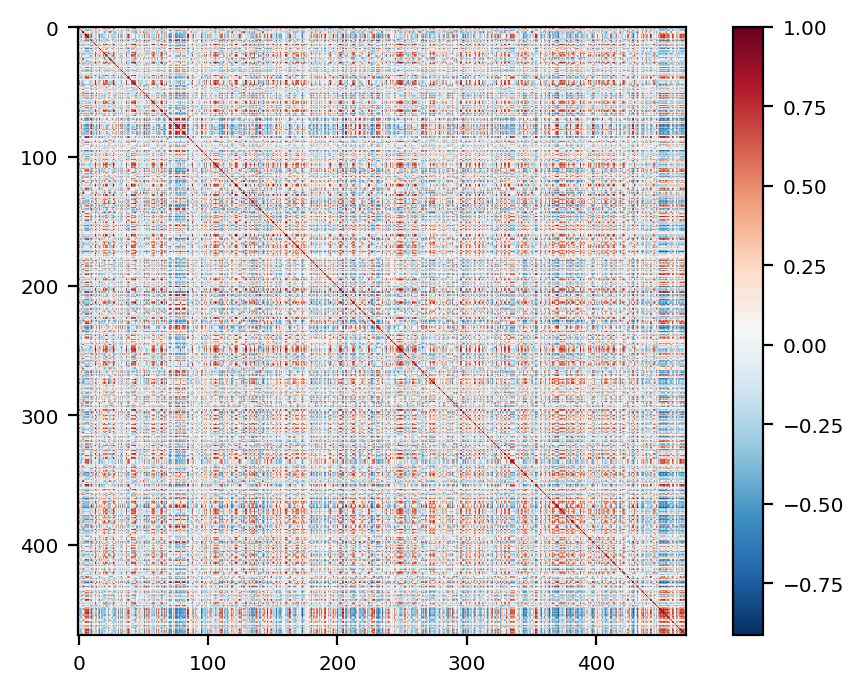

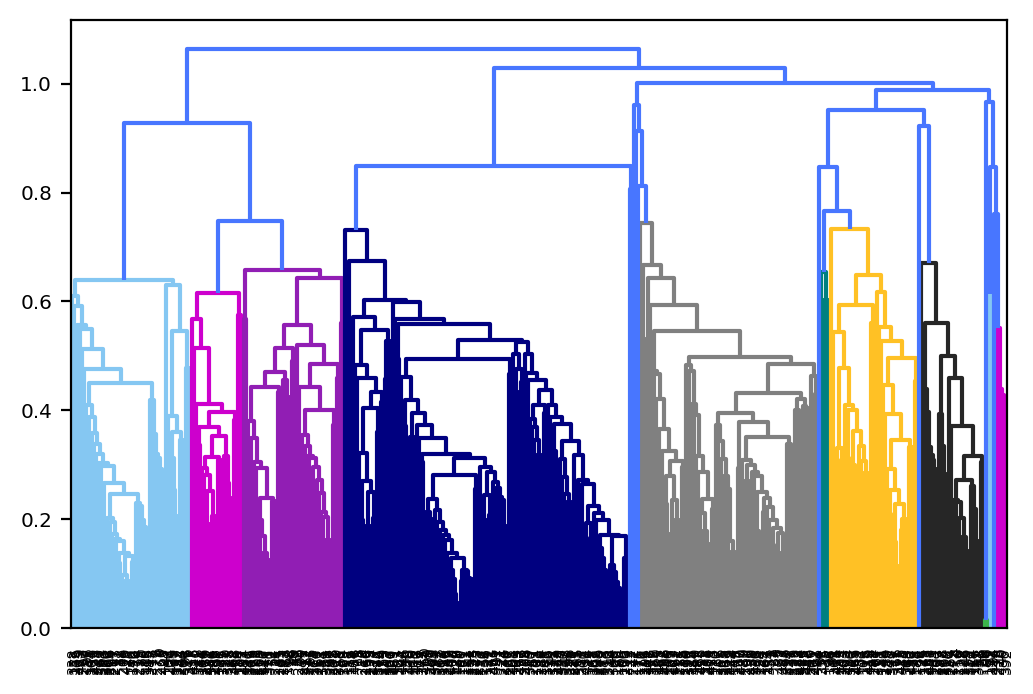

In [130]:
Xs = adata.layers['Ms']#adata.X.A#
Xu = adata.layers['Mu']
scaler = StandardScaler()#MinMaxScaler()#
X = scaler.fit_transform(Xs)

X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

X_corr_re=np.corrcoef(X_re, rowvar=False)
plt.show()

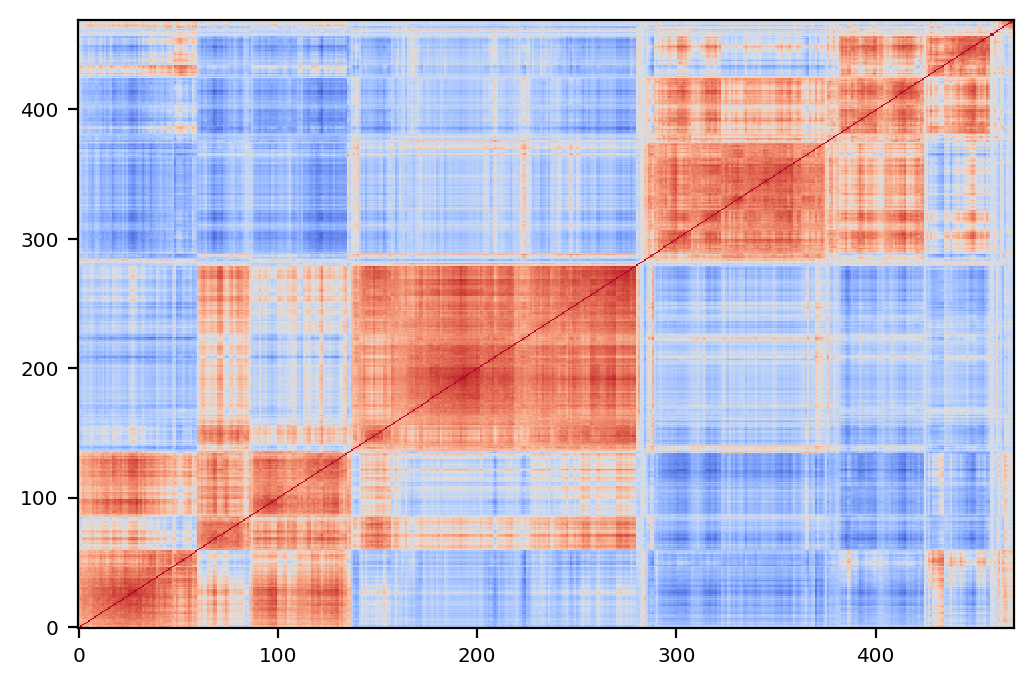

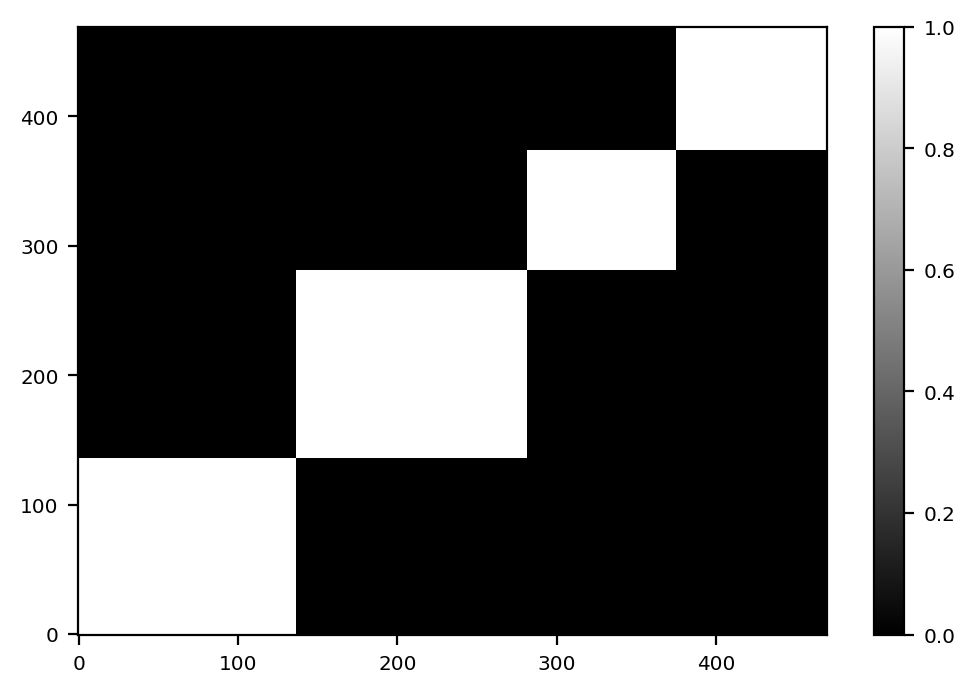

In [131]:
td = 0.996
T = fcluster(Z, t=td, criterion='distance')
# T=fcluster(Z, t=td, criterion='maxclust')
T_re = T[dg['leaves']]

plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
plt.show()

X_corr_label = np.zeros(X_corr_re.shape)
for i in range(X_corr_re.shape[0]):
    label_ind = np.where(T_re==T_re[i])[0]
    X_corr_label[i,label_ind] = 1

plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.gray, interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()

In [132]:
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        pca=PCA(n_components=5).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_.T)
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

In [133]:
eigen_X,eigen_X_w=eigen_gene(X_re,T_re)
eigen_dim=len(np.unique(T_re))
print(eigen_dim)

[0.47903928 0.16116218 0.04193589 0.02105384 0.0111175 ]
[0.61344254 0.07112858 0.02200385 0.01536505 0.01197575]
[0.583188   0.06347721 0.02849754 0.02087667 0.02023837]
[0.41759726 0.11689904 0.05901001 0.03280904 0.02705378]
4


In [134]:
n_eigen = 1
cell_eigen_X = eigen_X[0,:,:n_eigen]
for i in range(eigen_dim-1):
    cell_eigen_X = np.hstack((cell_eigen_X,eigen_X[i+1,:,:n_eigen]))

In [135]:
from torch.optim import SGD
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(cell_eigen_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.002, weight_decay=0.001)

x_in=torch.tensor(cell_eigen_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
    # print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_pEg = np.zeros([cell_eigen_X.shape[0], L*2, cell_eigen_X.shape[1]])

# Compute the gradients
for i in range(cell_eigen_X.shape[0]):
    x0=torch.tensor(cell_eigen_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pEg[i,j,:] = x0.grad.detach()
print(pZ_pEg.shape)
print(loss_fn(model(x_in),x_out))

(1718, 20, 4)
tensor(1.0810, grad_fn=<MseLossBackward0>)


In [136]:
eigen_gij = np.zeros((X.shape[0],eigen_dim*n_eigen,eigen_dim*n_eigen))
for i in range(X.shape[0]):
    eigen_gij[i] = pZ_pEg[i].T @ Fisher_g[i] @ pZ_pEg[i]

In [137]:
X_standard = np.zeros(Xs.shape)
velo_standard = np.zeros(Xs.shape)
velo = velo_pca@adata.varm['PCs'].T
# velo = velo_pca@np.linalg.pinv(adata.varm['PCs'])
for j in range(Xs.shape[1]):
    X_mean = np.mean(Xs[:,j])
    X_std = np.std(Xs[:,j])
    X_standard[:,j] = (Xs[:,j]-X_mean)/X_std
    velo_standard[:,j] = velo[:,j]/X_std

In [138]:
velo_re = velo_standard[:,dg['leaves']]
velo_eigen = np.zeros(cell_eigen_X.shape) # eigen gene 上的速度分量
for i in range(eigen_dim):
    velo_eigen[:,i*n_eigen:(i+1)*n_eigen] = velo_re[:,T_re==i+1]@eigen_X_w[i][:,:n_eigen]

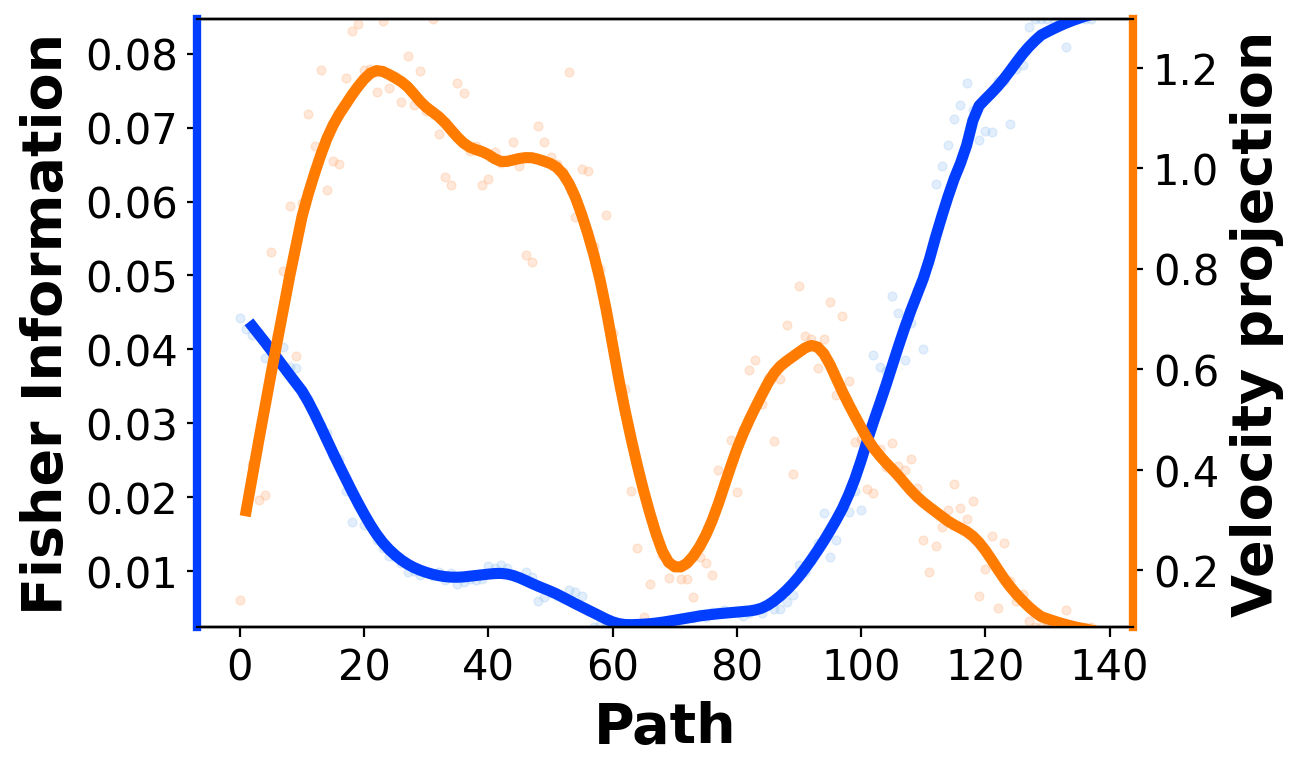

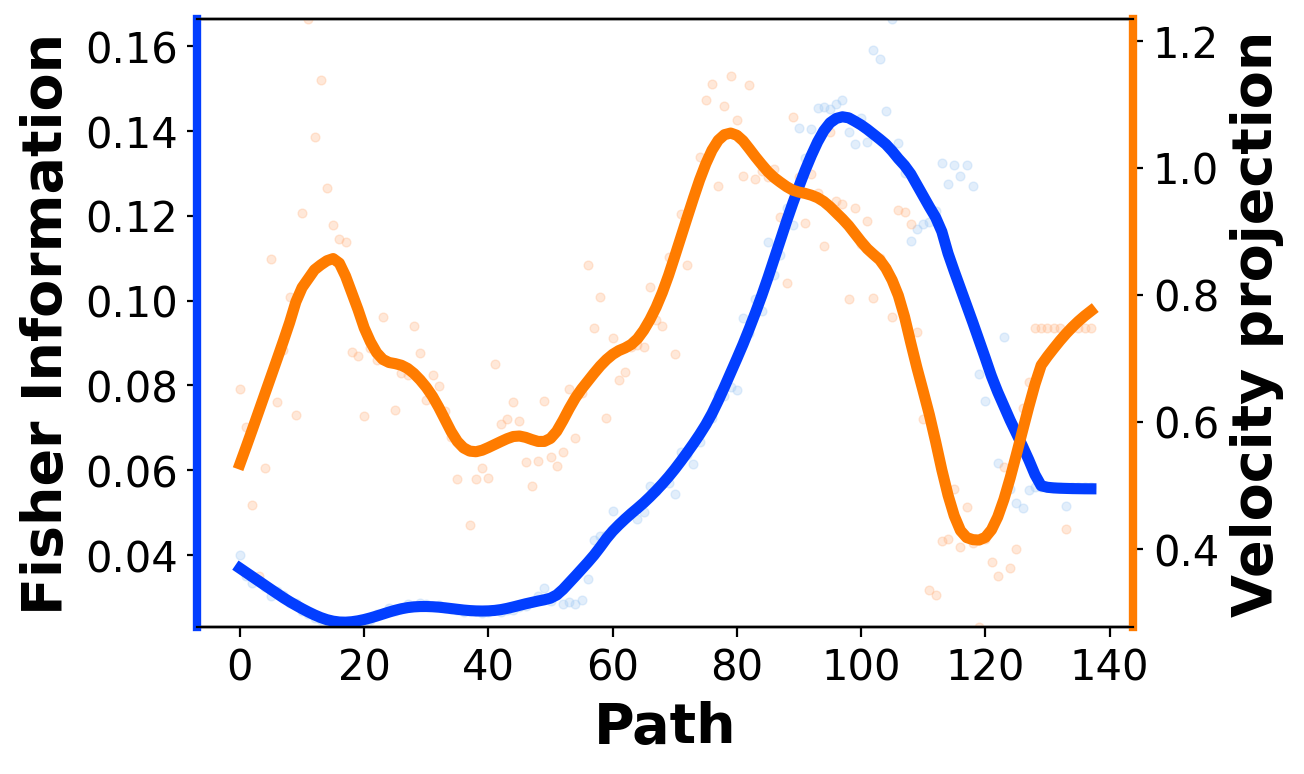

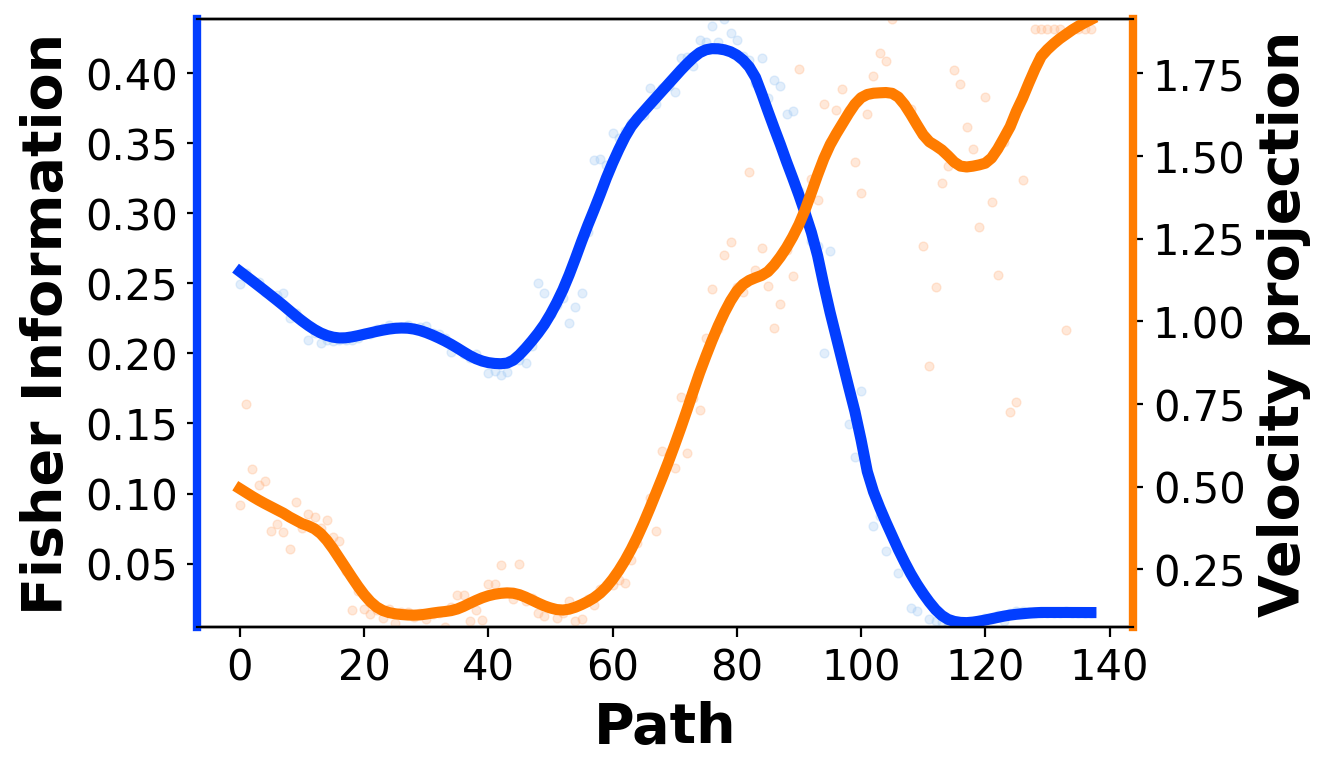

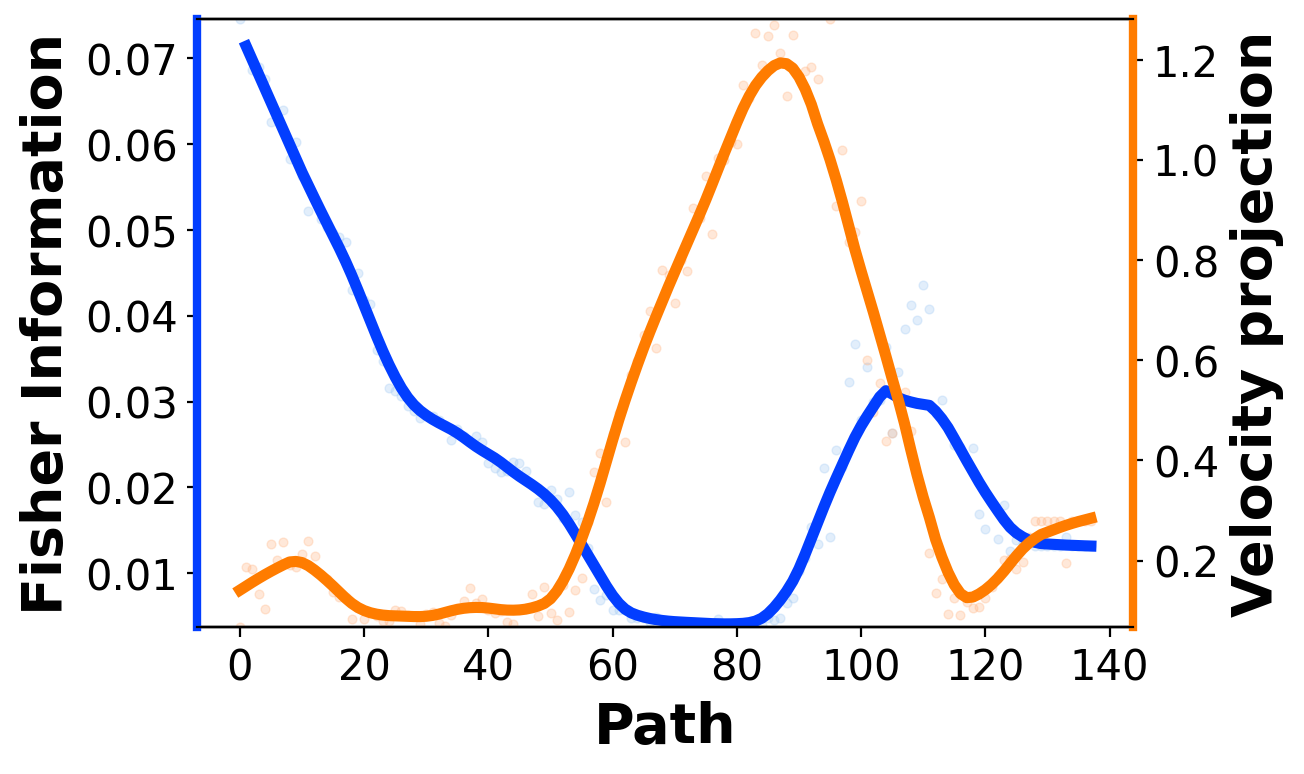

In [139]:
alpha = 0.3
frac = 0.13
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)
velo_pro = Z_velo

# for i in range(hs_dim):
#     plt.scatter(cell_vpt[:],smooth_func(Fisher_hs[:,i,i]),s=30)
#     plt.scatter(cell_vpt[:],smooth_func(np.abs(velo_pro[:,-(i+1)])),s=30)
    
#     plt.show()


for i in range(eigen_dim):
# plt.figure(dpi=600,bbox_inches='tight')
    mask1,x_ls1,y_ls1 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(eigen_gij[:,i,i])[nearest_indices],frac=frac)
    plt.scatter(range(nearest_indices.shape[0]), smooth_func(eigen_gij[:,i,i])[nearest_indices],c=palette2[0],s=10,alpha=alpha)
    mask2,x_ls2,y_ls2 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(np.abs(velo_eigen[:,i]))[nearest_indices],frac=frac)

    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('Fisher Information',fontsize=20,weight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ymin1 = min(smooth_func(eigen_gij[:,i,i])[nearest_indices])
    ymax1 = max(smooth_func(eigen_gij[:,i,i])[nearest_indices])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    plt.scatter(np.array(range(nearest_indices.shape[0])), smooth_func(np.abs(velo_eigen[:,i]))[nearest_indices],c=palette2[1],s=10,alpha=alpha)
    plt.yticks([])
    ymin2 = min(smooth_func(np.abs(velo_eigen[:,i]))[nearest_indices])
    ymax2 = max(smooth_func(np.abs(velo_eigen[:,i]))[nearest_indices])
    plt.ylim(ymin2,ymax2)

    plt.twinx()
    ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$FI$')

    plt.yticks([])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    # # ln3 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[1],label='$g_{'+str(ei)+str(ej)+'}$')
    ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[1],label='$Velo$')
    plt.ylabel('Velocity projection',fontsize=20,weight='bold')
    plt.yticks(fontsize=15)
    plt.ylim(ymin2,ymax2)

    ax = plt.gca()
    ax.spines['left'].set_color(palette1[0])
    ax.spines['right'].set_color(palette1[1])
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    # plt.legend(handles=ln1+ln2,fontsize=15)
    plt.savefig(figure_path+f'eigengene_path_action{i}.png',dpi=600,bbox_inches='tight')
    plt.show()   

## **plot on eigengene eigen direction** ##

In [140]:
# Eigen decompostion for Fisher_eigengene
g_eig = [0]*X.shape[0]
for i in range(X.shape[0]):
    g_eig[i] = np.linalg.eigh(eigen_gij[i])

gij_eig = np.array([g_eig[i][0] for i in range(X.shape[0])])
gij_eig[np.where(gij_eig<0)] = 0
velo_eig = np.abs(np.array([(velo_eigen[i]@g_eig[i][1]) for i in range(X.shape[0])]))
zv1_eig = np.array([np.sqrt(velo_eig[i]**2*gij_eig[i]) for i in range(X.shape[0])])

In [141]:
velo_pro = np.zeros_like(velo_eig)
eigen_values = np.zeros([X.shape[0],eigen_dim])
for i in range(X.shape[0]):
    velo_pro[i] = g_eig[i][1].T@velo_eig[i] # velocity projection on eigen vectors
    eigen_values[i,:] = g_eig[i][0]

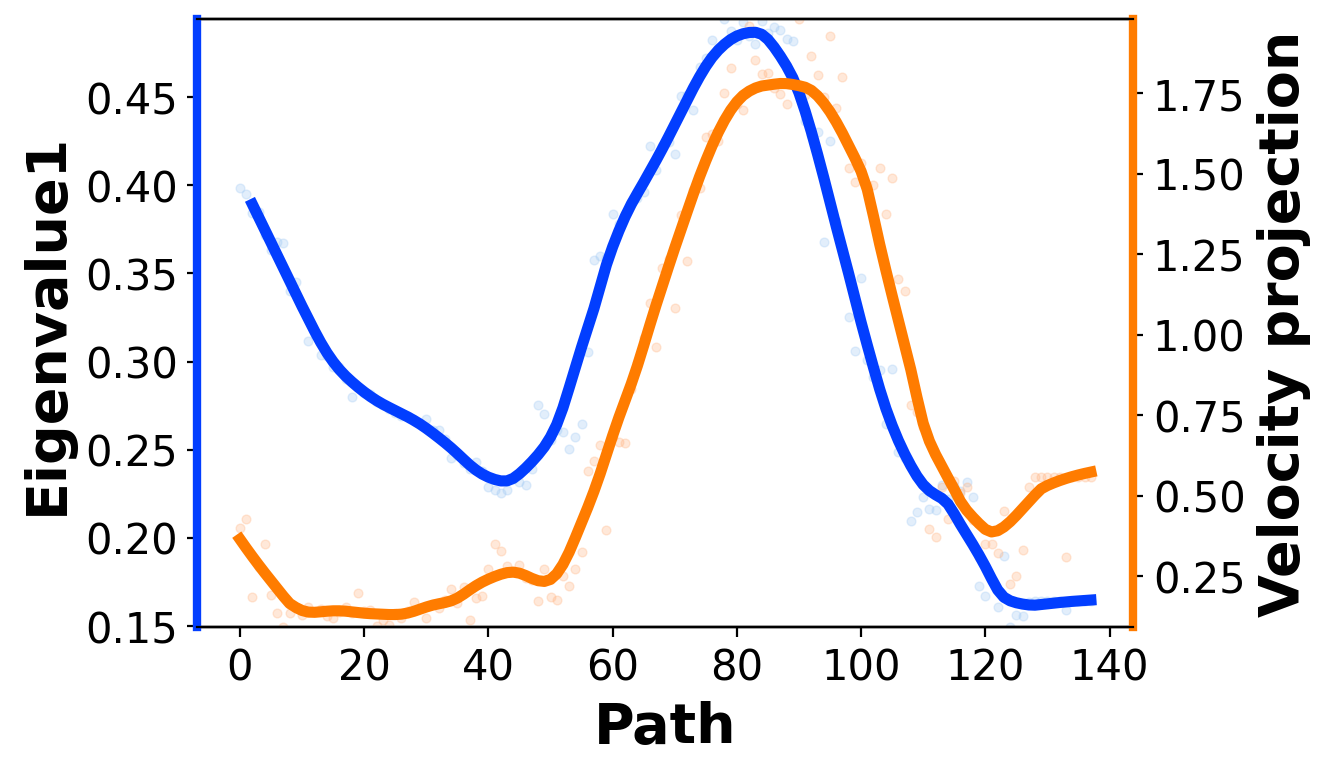

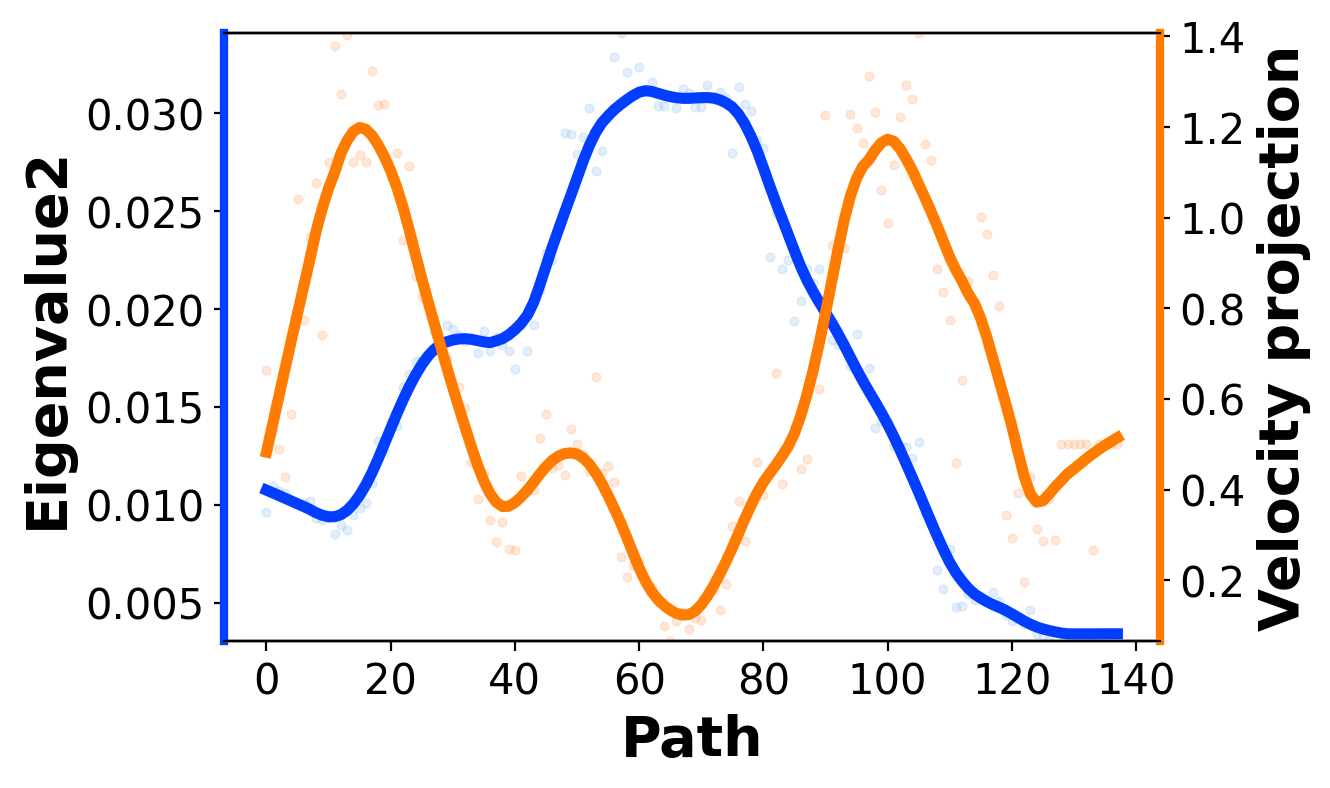

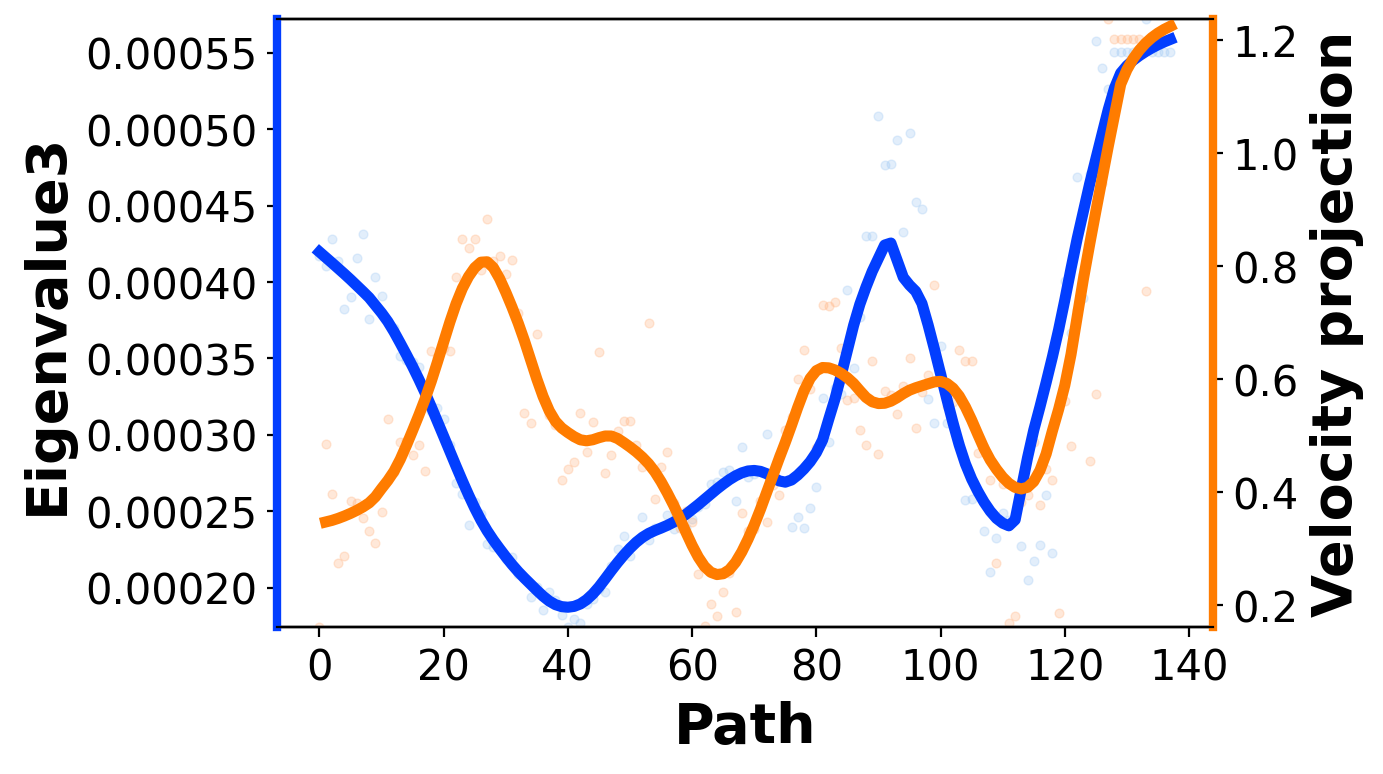

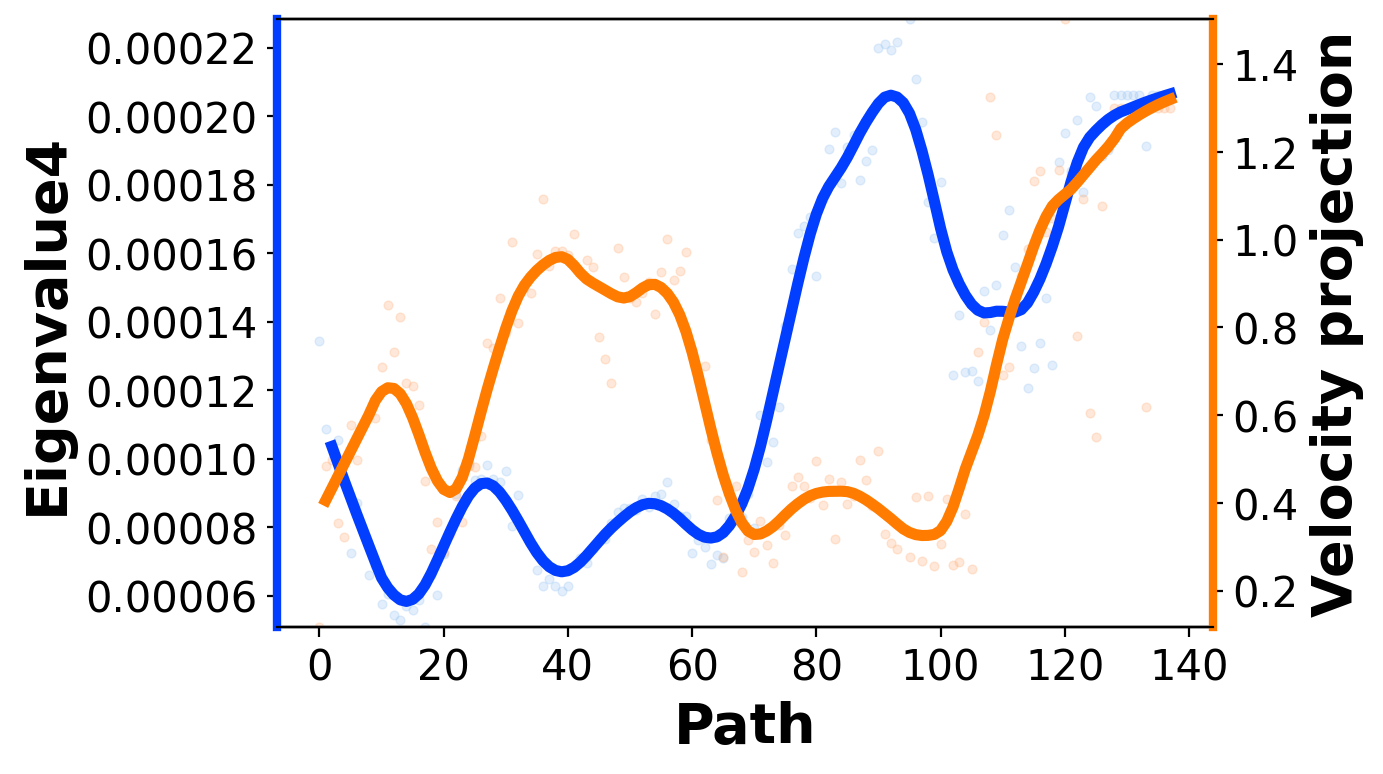

In [142]:
alpha = 0.3
frac = 0.13
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)

# for i in range(hs_dim):
#     plt.scatter(cell_vpt[:],smooth_func(Fisher_hs[:,i,i]),s=30)
#     plt.scatter(cell_vpt[:],smooth_func(np.abs(velo_pro[:,-(i+1)])),s=30)
    
#     plt.show()


for i in range(eigen_dim):
# plt.figure(dpi=600,bbox_inches='tight')
    mask1,x_ls1,y_ls1 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(eigen_values[:,-(i+1)])[nearest_indices],frac=frac)
    plt.scatter(range(nearest_indices.shape[0]), smooth_func(eigen_values[:,-(i+1)])[nearest_indices],c=palette2[0],s=10,alpha=alpha)
    mask2,x_ls2,y_ls2 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(np.abs(velo_pro[:,-(i+1)]))[nearest_indices],frac=frac)

    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel(f'Eigenvalue{i+1}',fontsize=20,weight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ymin1 = min(smooth_func(eigen_values[:,-(i+1)])[nearest_indices])
    ymax1 = max(smooth_func(eigen_values[:,-(i+1)])[nearest_indices])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    plt.scatter(np.array(range(nearest_indices.shape[0])), smooth_func(np.abs(velo_pro[:,-(i+1)]))[nearest_indices],c=palette2[1],s=10,alpha=alpha)
    plt.yticks([])
    ymin2 = min(smooth_func(np.abs(velo_pro[:,-(i+1)]))[nearest_indices])
    ymax2 = max(smooth_func(np.abs(velo_pro[:,-(i+1)]))[nearest_indices])
    plt.ylim(ymin2,ymax2)

    plt.twinx()
    ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$FI$')

    plt.yticks([])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    # # ln3 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[1],label='$g_{'+str(ei)+str(ej)+'}$')
    ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[1],label='$Velo$')
    plt.ylabel('Velocity projection',fontsize=20,weight='bold')
    plt.yticks(fontsize=15)
    plt.ylim(ymin2,ymax2)

    ax = plt.gca()
    ax.spines['left'].set_color(palette1[0])
    ax.spines['right'].set_color(palette1[1])
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    # plt.legend(handles=ln1+ln2,fontsize=15)
    plt.savefig(figure_path+f'eigengene_eigendirection_path_action{i}.png',dpi=600,bbox_inches='tight')
    plt.show()  

## **plot on hotspot** ##

In [143]:
import hotspot
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
hs = hotspot.Hotspot(
    adata, 
    model='danb',
    distances_obsp_key = 'distances'
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=k_nei,
)

hs_results = hs.compute_autocorrelations(jobs=1)

# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.1].sort_values('Z', ascending=False).head(800).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=1)

modules = hs.create_modules(
    min_gene_threshold=40, core_only=True, fdr_threshold=0.1
)

modules.value_counts()
# np.save(result_path+'modules', modules.values)
# np.save(result_path+'hs_genes', hs_genes)

100%|██████████| 470/470 [00:00<00:00, 3258.02it/s]


Computing pair-wise local correlation on 461 features...


100%|██████████| 106030/106030 [00:02<00:00, 49419.43it/s]


Module
 1    164
 2    121
 3     95
 4     65
-1     16
Name: count, dtype: int64

In [144]:
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        if i < 0:
            continue
        pca=PCA(n_components=2).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

In [145]:
adata_hs = adata[:,hs_genes] # 只用hotspot有效的gene
T_hs = np.array(hs.modules.tolist()) # 记录所有hs gene的module

scaler = StandardScaler()
X_hs = scaler.fit_transform(adata_hs.layers['Ms'])
hs_X, hs_X_w = eigen_gene(X_hs,T_hs)
hs_dim=len(hs_X_w)
print(hs_dim)

[0.5656165 0.1105013]
[0.51548296 0.12865748]
[0.5733457  0.06515982]
[0.5697533 0.1061097]
4


In [146]:
cell_hs_X=np.zeros((X_hs.shape[0],hs_dim))
for j in range(X_hs.shape[0]):
    for k in range(len(hs_X_w)):
        cell_hs_X[j,k]=np.dot(hs_X_w[k],X_hs[j,T_hs==k+1])

In [147]:
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(cell_hs_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(cell_hs_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
#         print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_phs = np.zeros([cell_hs_X.shape[0], L*2, cell_hs_X.shape[1]])

# Compute the gradients
for i in range(cell_hs_X.shape[0]):
    x0=torch.tensor(cell_hs_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_phs[i,j,:] = x0.grad.detach()
print(pZ_phs.shape)

(1718, 20, 4)


In [148]:
Fisher_hs = np.zeros((X.shape[0],hs_dim, hs_dim))
for i in range(X.shape[0]):
    Fisher_hs[i] = pZ_phs[i].T@Fisher_g[i]@pZ_phs[i]

In [149]:
X_standard = np.zeros(adata_hs.layers['Ms'].shape)
velo_standard = np.zeros(adata_hs.layers['Ms'].shape)
velo = adata_hs.layers['velocity']
# velo = velo_pca@np.linalg.pinv(adata.varm['PCs'])
for j in range(adata_hs.layers['Ms'].shape[1]):
    X_mean = np.mean(adata_hs.layers['Ms'][:,j])
    X_std = np.std(adata_hs.layers['Ms'][:,j])
    X_standard[:,j] = (adata_hs.layers['Ms'][:,j]-X_mean)/X_std
    velo_standard[:,j] = velo[:,j]/X_std

In [150]:
velo_re = velo_standard
velo_eigen = np.zeros(cell_hs_X.shape) # hotspot gene 上的速度分量
for i in range(hs_dim):
    velo_eigen[:,i] = velo_re[:,T_hs==i+1]@hs_X_w[i][:]

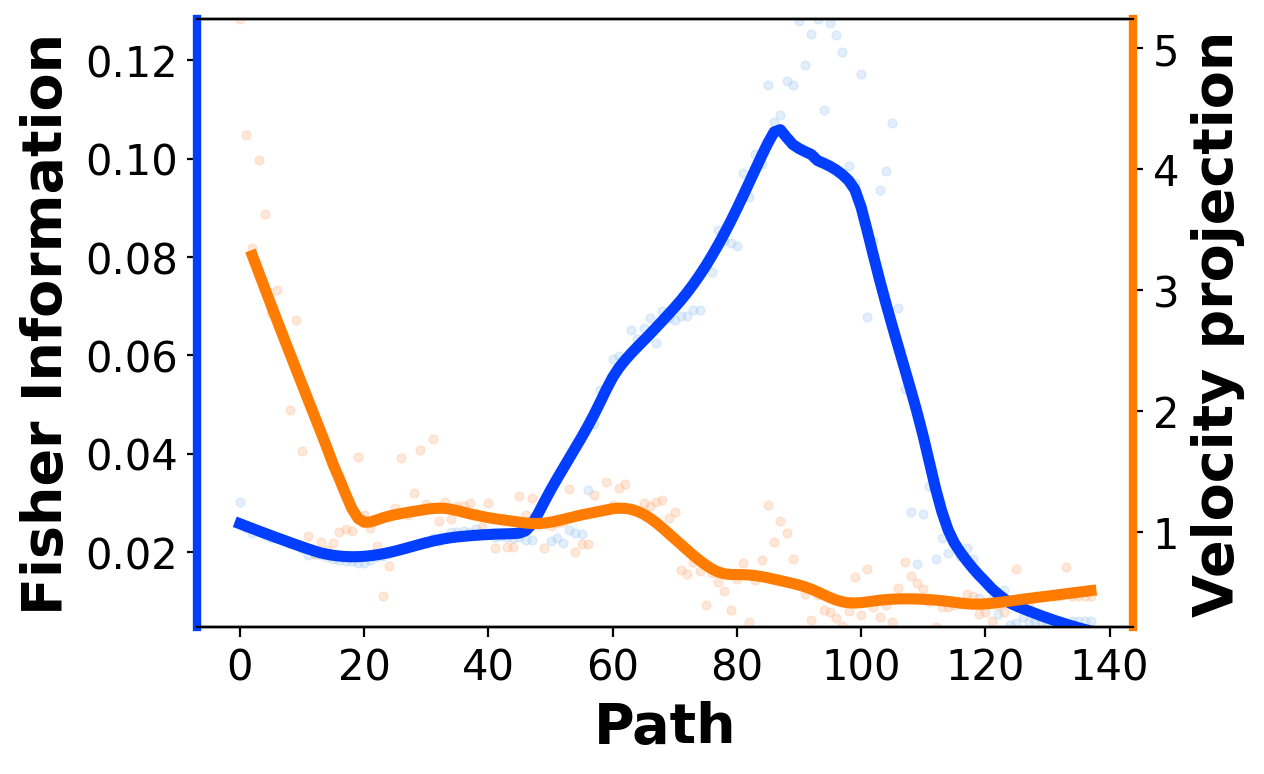

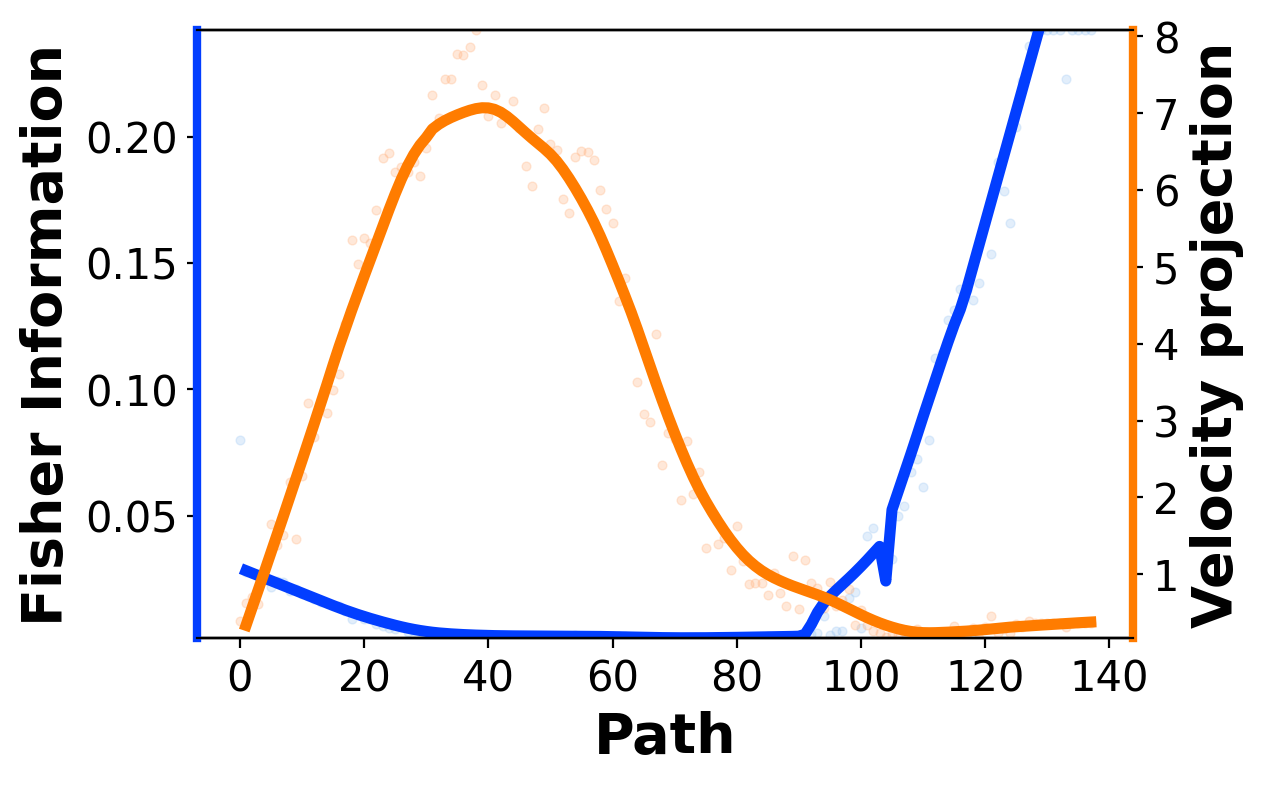

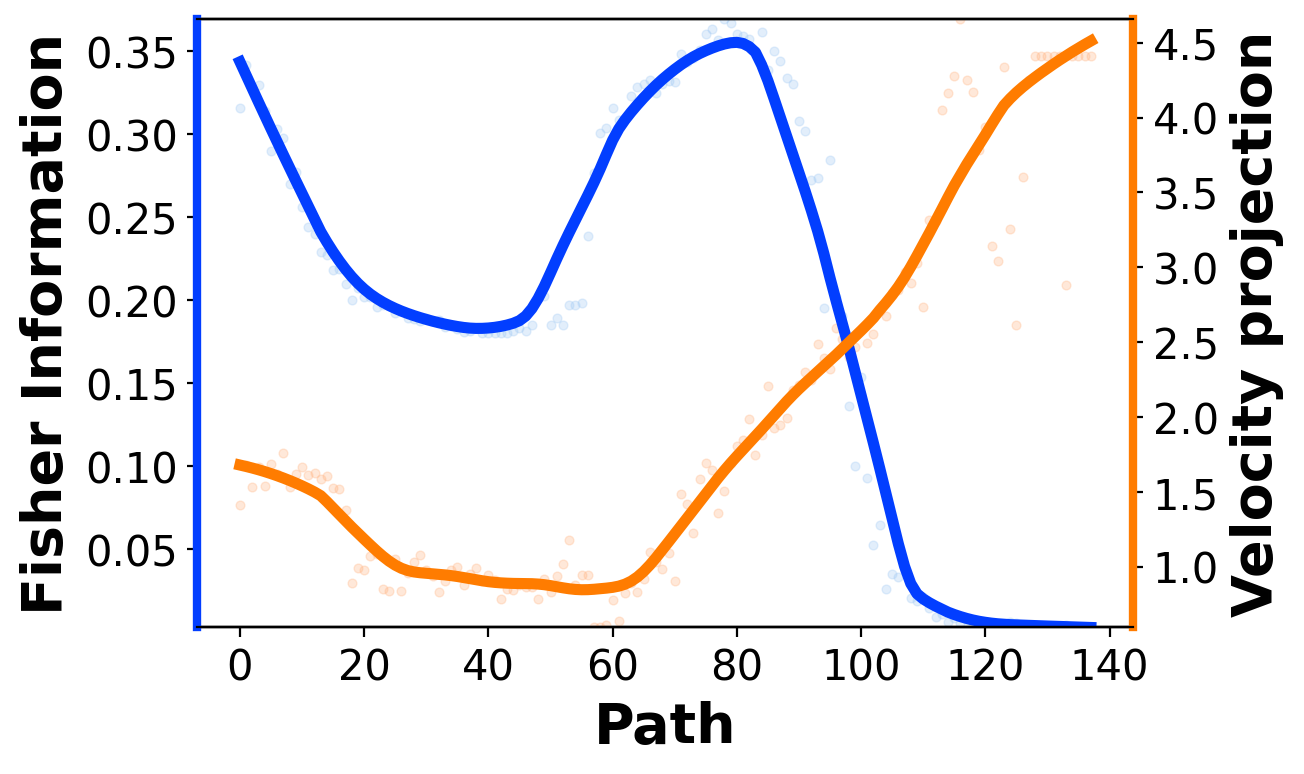

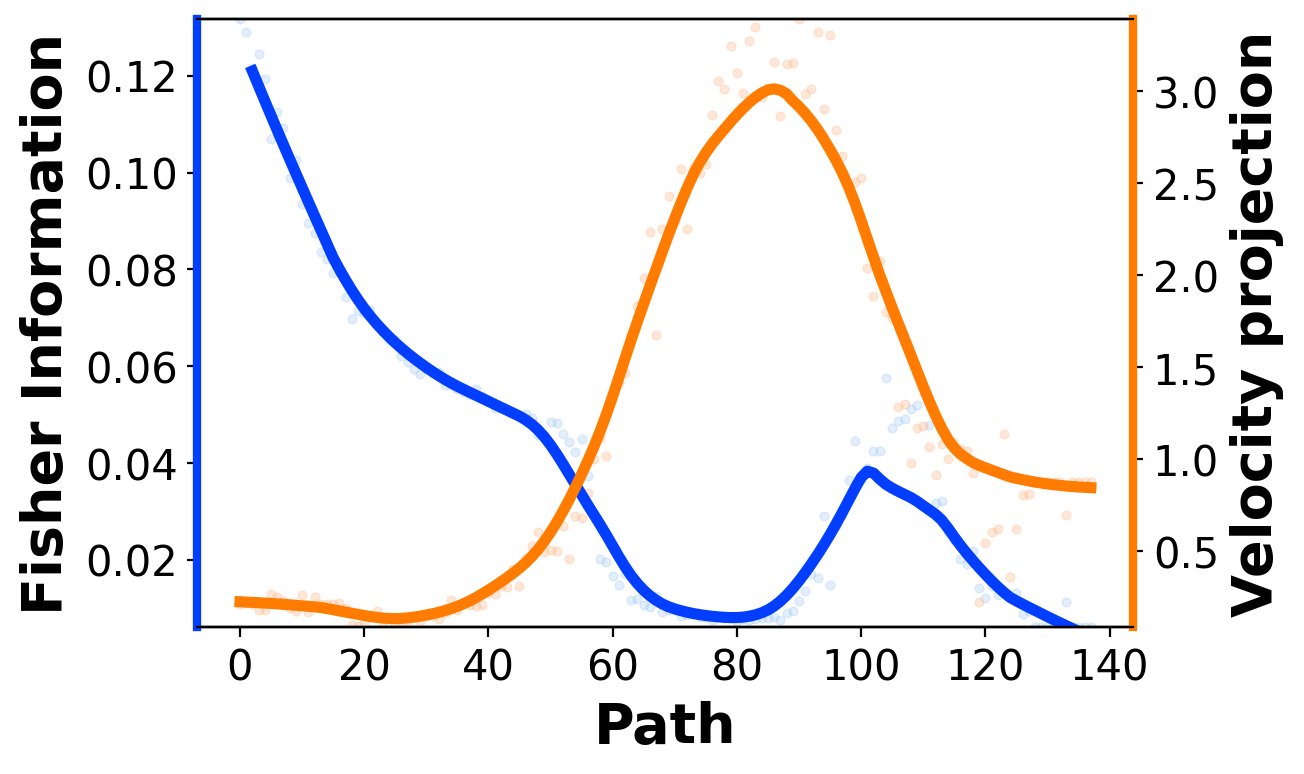

In [151]:
alpha = 0.3
frac = 0.2
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)
velo_pro = Z_velo

# for i in range(hs_dim):
#     plt.scatter(cell_vpt[:],smooth_func(Fisher_hs[:,i,i]),s=30)
#     plt.scatter(cell_vpt[:],smooth_func(np.abs(velo_pro[:,-(i+1)])),s=30)
    
#     plt.show()


for i in range(hs_dim):
# plt.figure(dpi=600,bbox_inches='tight')
    mask1,x_ls1,y_ls1 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(Fisher_hs[:,i,i])[nearest_indices],frac=frac)
    plt.scatter(range(nearest_indices.shape[0]), smooth_func(Fisher_hs[:,i,i])[nearest_indices],c=palette2[0],s=10,alpha=alpha)
    mask2,x_ls2,y_ls2 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(np.abs(velo_eigen[:,i]))[nearest_indices],frac=frac)

    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('Fisher Information',fontsize=20,weight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ymin1 = min(smooth_func(Fisher_hs[:,i,i])[nearest_indices])
    ymax1 = max(smooth_func(Fisher_hs[:,i,i])[nearest_indices])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    plt.scatter(np.array(range(nearest_indices.shape[0])), smooth_func(np.abs(velo_eigen[:,i]))[nearest_indices],c=palette2[1],s=10,alpha=alpha)
    plt.yticks([])
    ymin2 = min(smooth_func(np.abs(velo_eigen[:,i]))[nearest_indices])
    ymax2 = max(smooth_func(np.abs(velo_eigen[:,i]))[nearest_indices])
    plt.ylim(ymin2,ymax2)

    plt.twinx()
    ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$FI$')

    plt.yticks([])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    # # ln3 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[1],label='$g_{'+str(ei)+str(ej)+'}$')
    ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[1],label='$Velo$')
    plt.ylabel('Velocity projection',fontsize=20,weight='bold')
    plt.yticks(fontsize=15)
    plt.ylim(ymin2,ymax2)

    ax = plt.gca()
    ax.spines['left'].set_color(palette1[0])
    ax.spines['right'].set_color(palette1[1])
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    # plt.legend(handles=ln1+ln2,fontsize=15)
    plt.savefig(figure_path+f'hotspot_path_action{i}.png',dpi=600,bbox_inches='tight')
    plt.show() 

## **plot on hotspot eigen direction** ##

In [152]:
g_eig = [0]*X.shape[0]
for i in range(X.shape[0]):
    g_eig[i] = np.linalg.eigh(Fisher_hs[i])

gij_eig = np.array([g_eig[i][0] for i in range(X.shape[0])])
gij_eig[np.where(gij_eig<0)] = 0
velo_eig = np.abs(np.array([(velo_eigen[i]@g_eig[i][1]) for i in range(X.shape[0])]))
zv1_eig = np.array([np.sqrt(velo_eig[i]**2*gij_eig[i]) for i in range(X.shape[0])])

In [153]:
velo_pro = np.zeros_like(velo_eig)
eigen_values = np.zeros([X.shape[0],hs_dim])
for i in range(X.shape[0]):
    velo_pro[i] = g_eig[i][1].T@velo_eig[i] # velocity projection on eigen vectors
    eigen_values[i,:] = g_eig[i][0]

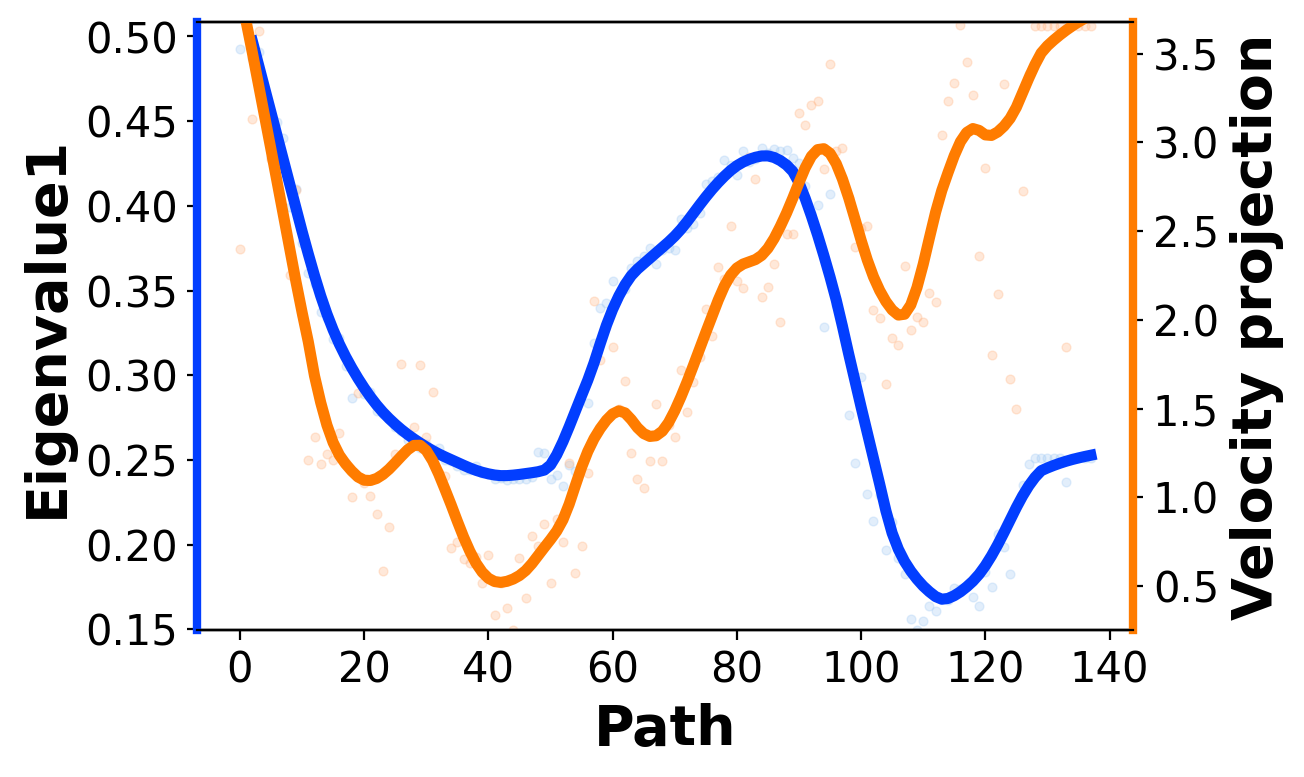

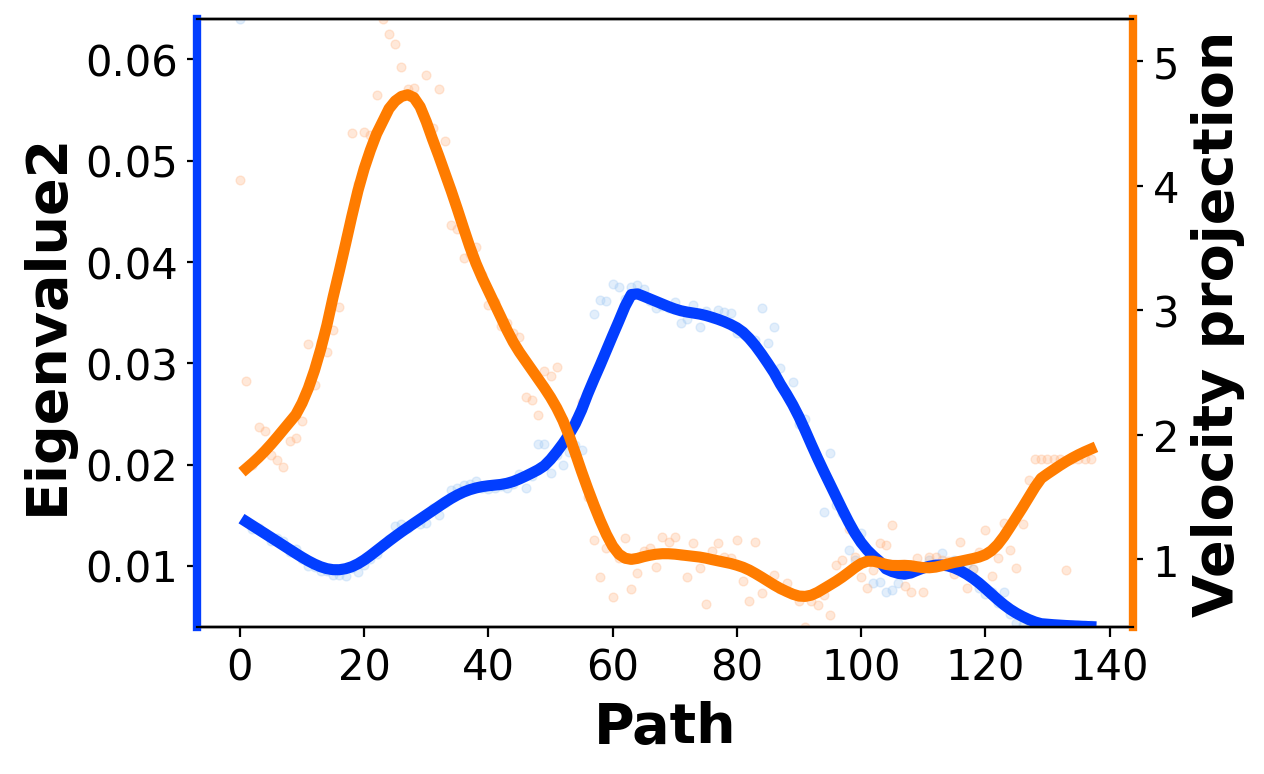

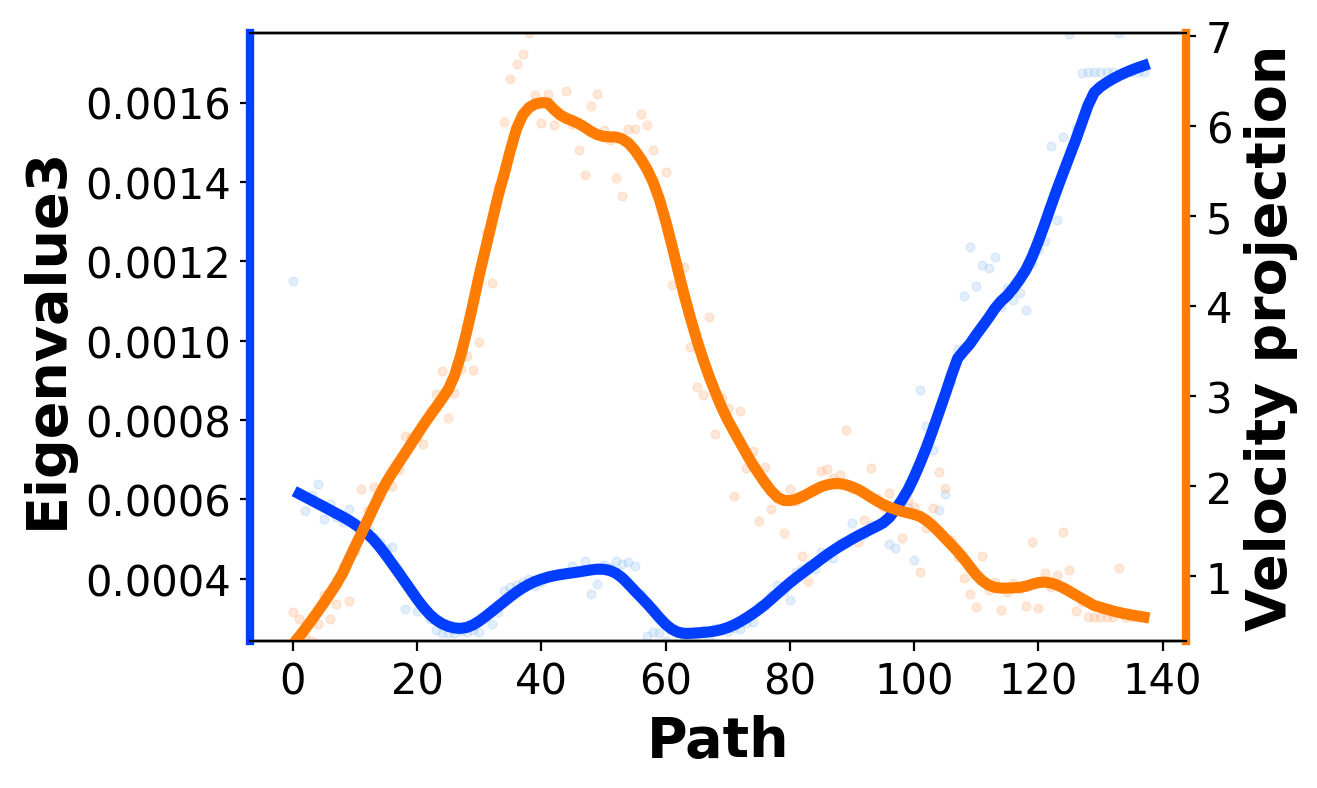

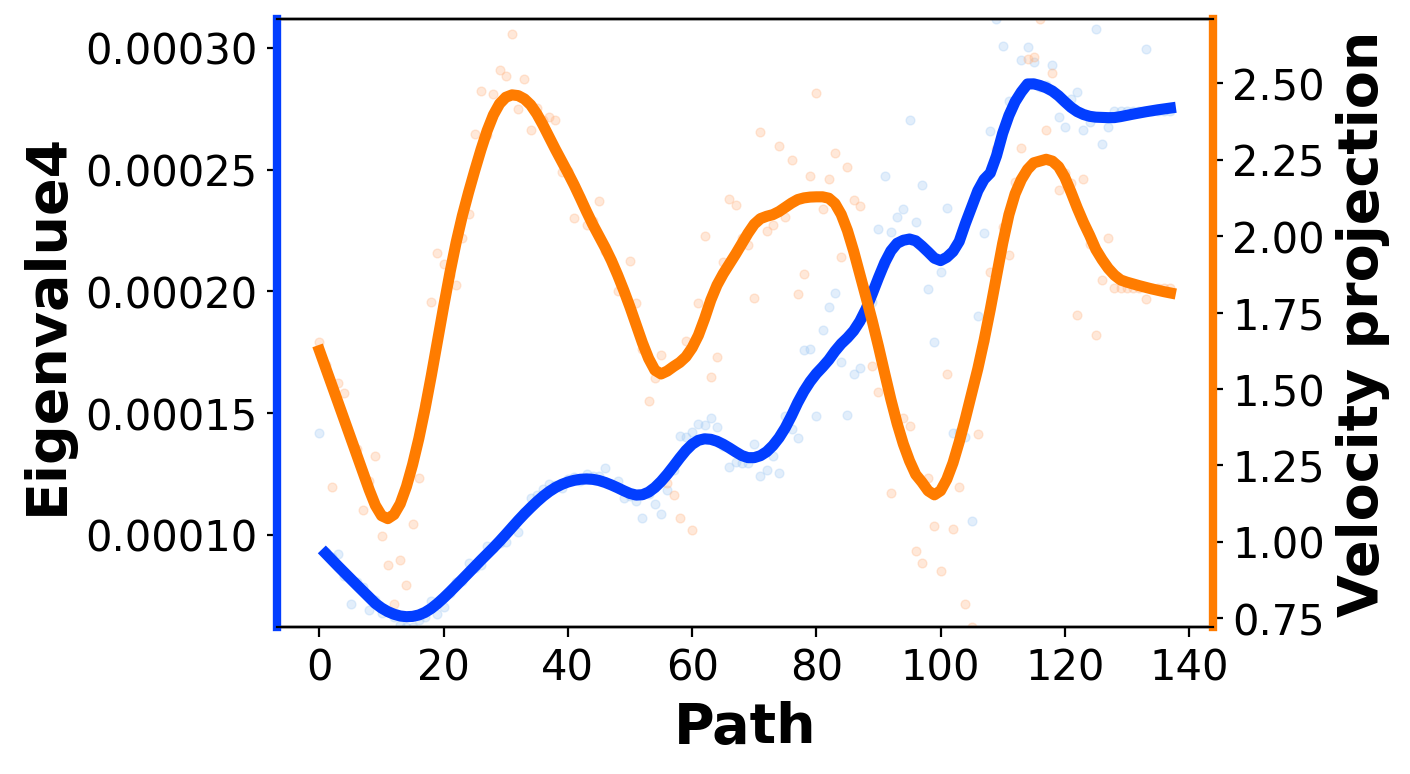

In [154]:
alpha = 0.3
frac = 0.13
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)


# for i in range(hs_dim):
#     plt.scatter(cell_vpt[:],smooth_func(Fisher_hs[:,i,i]),s=30)
#     plt.scatter(cell_vpt[:],smooth_func(np.abs(velo_pro[:,-(i+1)])),s=30)
    
#     plt.show()


for i in range(hs_dim):
# plt.figure(dpi=600,bbox_inches='tight')
    mask1,x_ls1,y_ls1 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(eigen_values[:,-(i+1)])[nearest_indices],frac=frac)
    plt.scatter(range(nearest_indices.shape[0]), smooth_func(eigen_values[:,-(i+1)])[nearest_indices],c=palette2[0],s=10,alpha=alpha)
    mask2,x_ls2,y_ls2 = kde_lowess(np.array(range(nearest_indices.shape[0])),smooth_func(np.abs(velo_pro[:,-(i+1)]))[nearest_indices],frac=frac)

    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel(f'Eigenvalue{i+1}',fontsize=20,weight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ymin1 = min(smooth_func(eigen_values[:,-(i+1)])[nearest_indices])
    ymax1 = max(smooth_func(eigen_values[:,-(i+1)])[nearest_indices])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    plt.scatter(np.array(range(nearest_indices.shape[0])), smooth_func(np.abs(velo_pro[:,-(i+1)]))[nearest_indices],c=palette2[1],s=10,alpha=alpha)
    plt.yticks([])
    ymin2 = min(smooth_func(np.abs(velo_pro[:,-(i+1)]))[nearest_indices])
    ymax2 = max(smooth_func(np.abs(velo_pro[:,-(i+1)]))[nearest_indices])
    plt.ylim(ymin2,ymax2)

    plt.twinx()
    ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[0],label='$FI$')

    plt.yticks([])
    plt.ylim(ymin1,ymax1)

    plt.twinx()
    # # ln3 = plt.plot(x_ls3, y_ls3, linewidth=4,color=palette1[1],label='$g_{'+str(ei)+str(ej)+'}$')
    ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[1],label='$Velo$')
    plt.ylabel('Velocity projection',fontsize=20,weight='bold')
    plt.yticks(fontsize=15)
    plt.ylim(ymin2,ymax2)

    ax = plt.gca()
    ax.spines['left'].set_color(palette1[0])
    ax.spines['right'].set_color(palette1[1])
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    # plt.legend(handles=ln1+ln2,fontsize=15)
    plt.savefig(figure_path+f'hotspot_eigendirection_path_action{i}.png',dpi=600,bbox_inches='tight')
    plt.show()  

## **Curvature --> Transition point &&  Eigen spectrum** ##

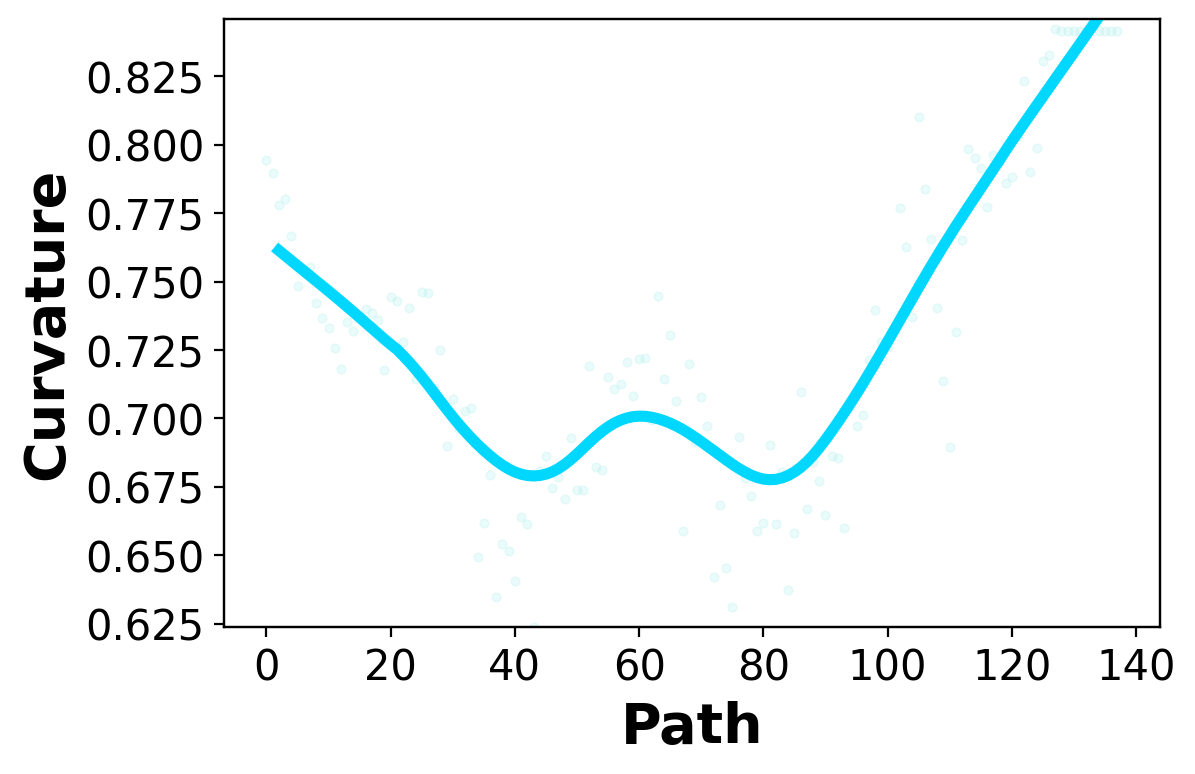

In [155]:
frac = 0.3
mask1,x_ls1,y_ls1 = kde_lowess(np.array(range(nearest_indices.shape[0])),crc_smooth[nearest_indices],frac=frac)
plt.scatter(range(nearest_indices.shape[0]), crc_smooth[nearest_indices],c=palette2[-1],s=10,alpha=alpha)


plt.xlabel('Path',fontsize=20,weight='bold')
plt.ylabel('Curvature',fontsize=20,weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ymin1 = min(crc_smooth[nearest_indices])
ymax1 = max(crc_smooth[nearest_indices])
plt.ylim(ymin1,ymax1)

plt.twinx()
ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=palette1[-1],label='$FI$')

plt.yticks([])
plt.ylim(ymin1,ymax1)
plt.savefig(figure_path+f'path_curvature.png',dpi=600,bbox_inches='tight')
plt.show()

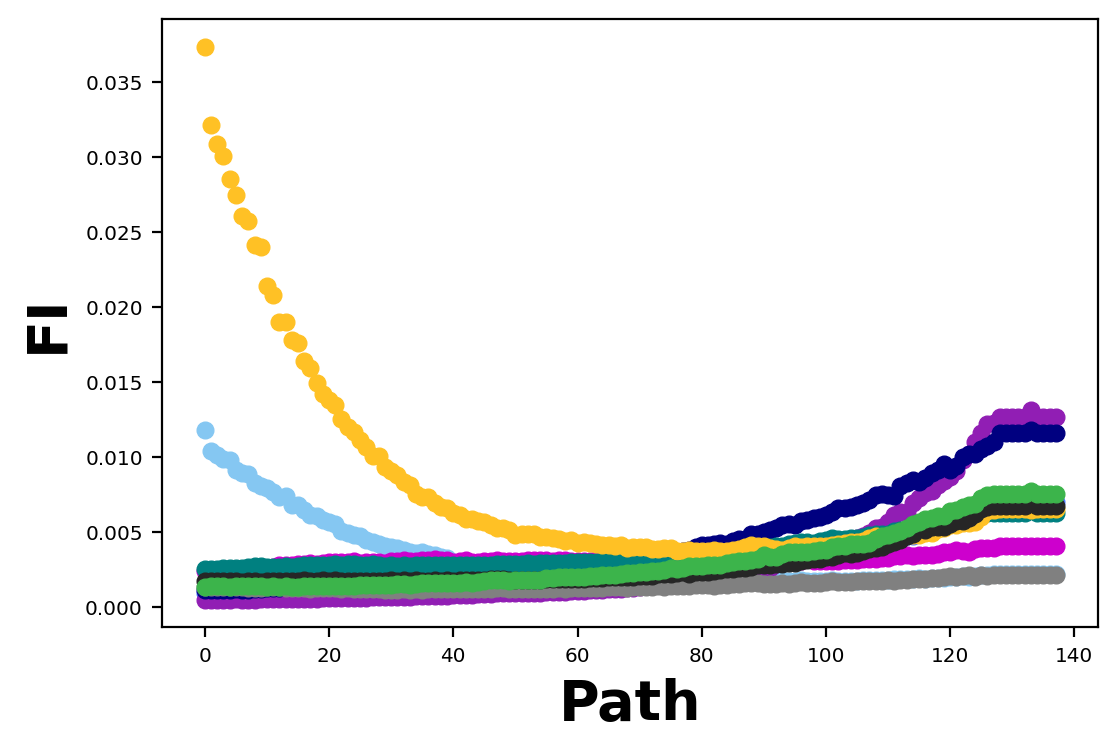

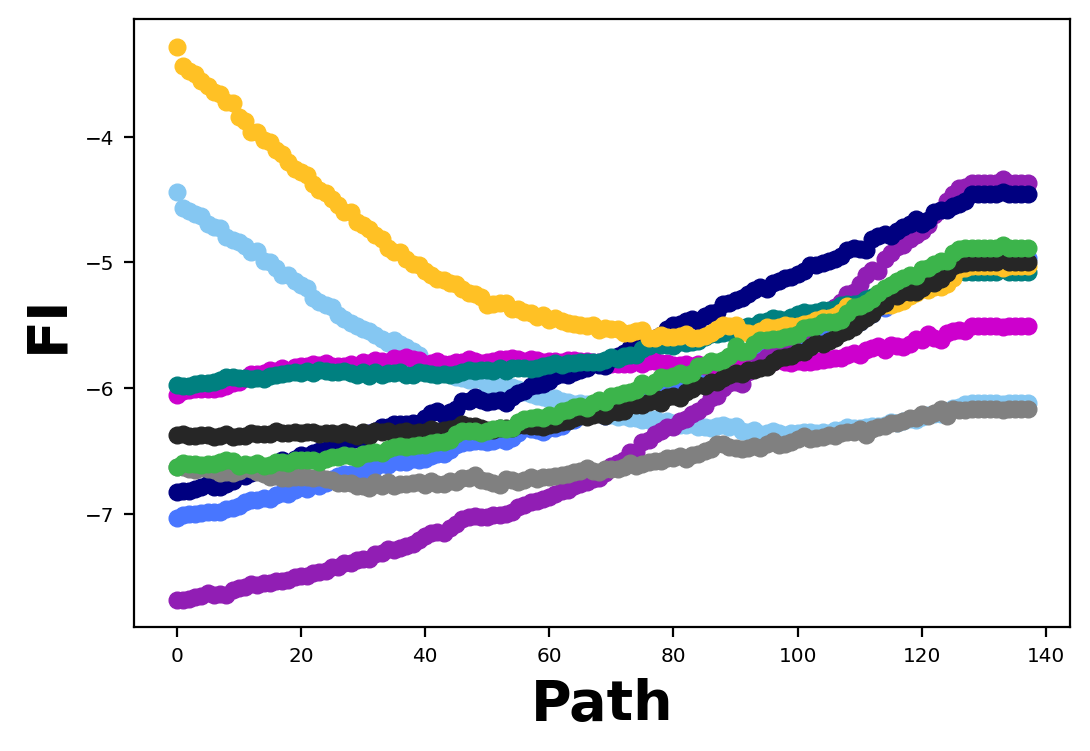

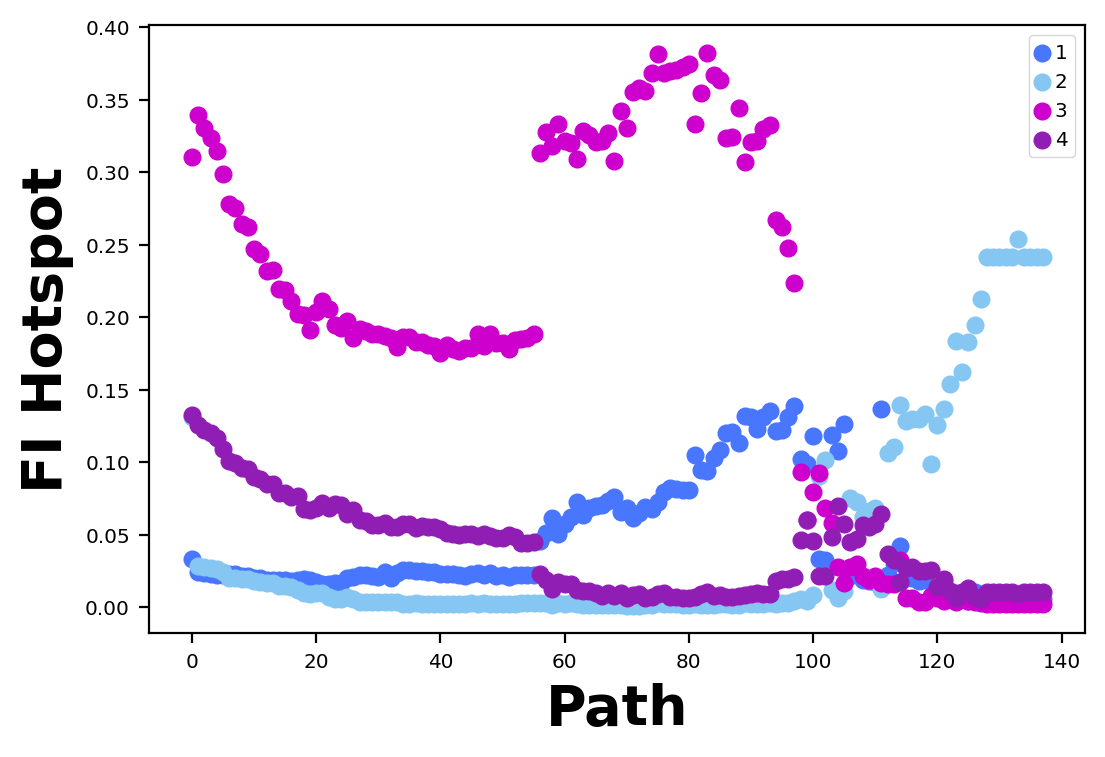

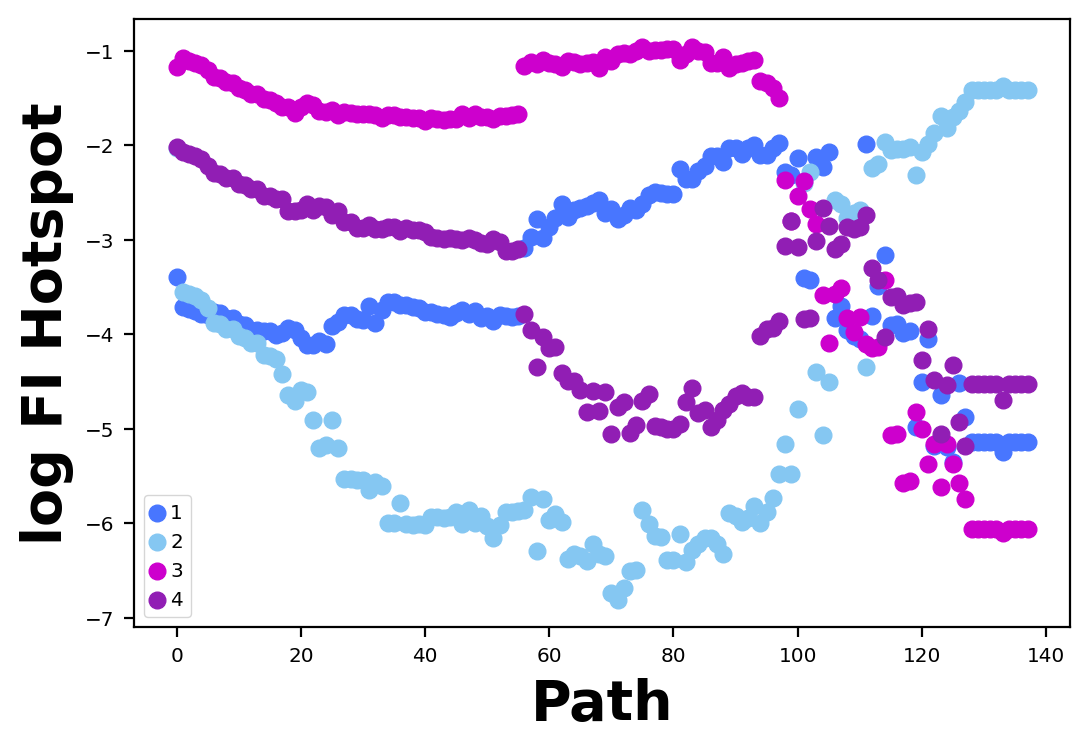

In [156]:
path_Fisher_g = Fisher_g[nearest_indices]
for i in range(path_Fisher_g.shape[1]//2):
    plt.scatter(np.array(range(path_Fisher_g.shape[0])),path_Fisher_g[:,i,i])
    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('FI',fontsize=20,weight='bold')
    plt.savefig(figure_path+f'path_fi.png',dpi=600,bbox_inches='tight')
plt.show()

for i in range(path_Fisher_g.shape[1]//2):
    plt.scatter(np.array(range(path_Fisher_g.shape[0])),np.log(path_Fisher_g[:,i,i]))
    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('FI',fontsize=20,weight='bold')
    plt.savefig(figure_path+f'path_log_fi.png',dpi=600,bbox_inches='tight')
plt.show()

path_Fisher_hs = Fisher_hs[nearest_indices]
for i in range(path_Fisher_hs.shape[1]):
    plt.scatter(np.array(range(path_Fisher_hs.shape[0])),path_Fisher_hs[:,i,i], label=f'{i+1}')
    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('FI Hotspot',fontsize=20,weight='bold')
plt.legend()
plt.savefig(figure_path+f'path_fi_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()

for i in range(path_Fisher_hs.shape[1]):
    plt.scatter(np.array(range(path_Fisher_hs.shape[0])),np.log(path_Fisher_hs[:,i,i]), label=f'{i+1}')
    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('log FI Hotspot',fontsize=20,weight='bold')
plt.legend()    
plt.savefig(figure_path+f'path_log_fi_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()

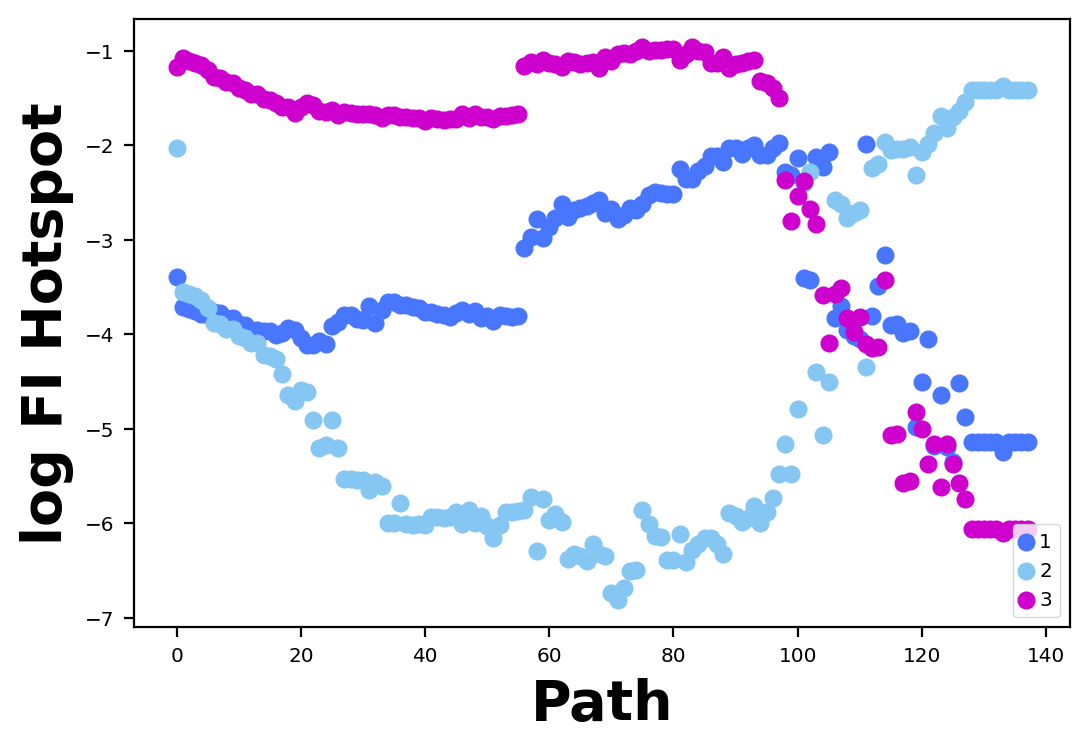

In [157]:
path_Fisher_hs = Fisher_hs[nearest_indices]
for i in [0,1,2]:
    plt.scatter(np.array(range(path_Fisher_hs.shape[0])),np.log(path_Fisher_hs[:,i,i]), label=f'{i+1}')
    plt.xlabel('Path',fontsize=20,weight='bold')
    plt.ylabel('log FI Hotspot',fontsize=20,weight='bold')
plt.legend(loc='lower right') 
plt.savefig(figure_path+f'path_log_fi_hotspot_selected.png',dpi=600,bbox_inches='tight')
plt.show()

Computing scores for 4 modules...


100%|██████████| 4/4 [00:00<00:00, 38.86it/s]


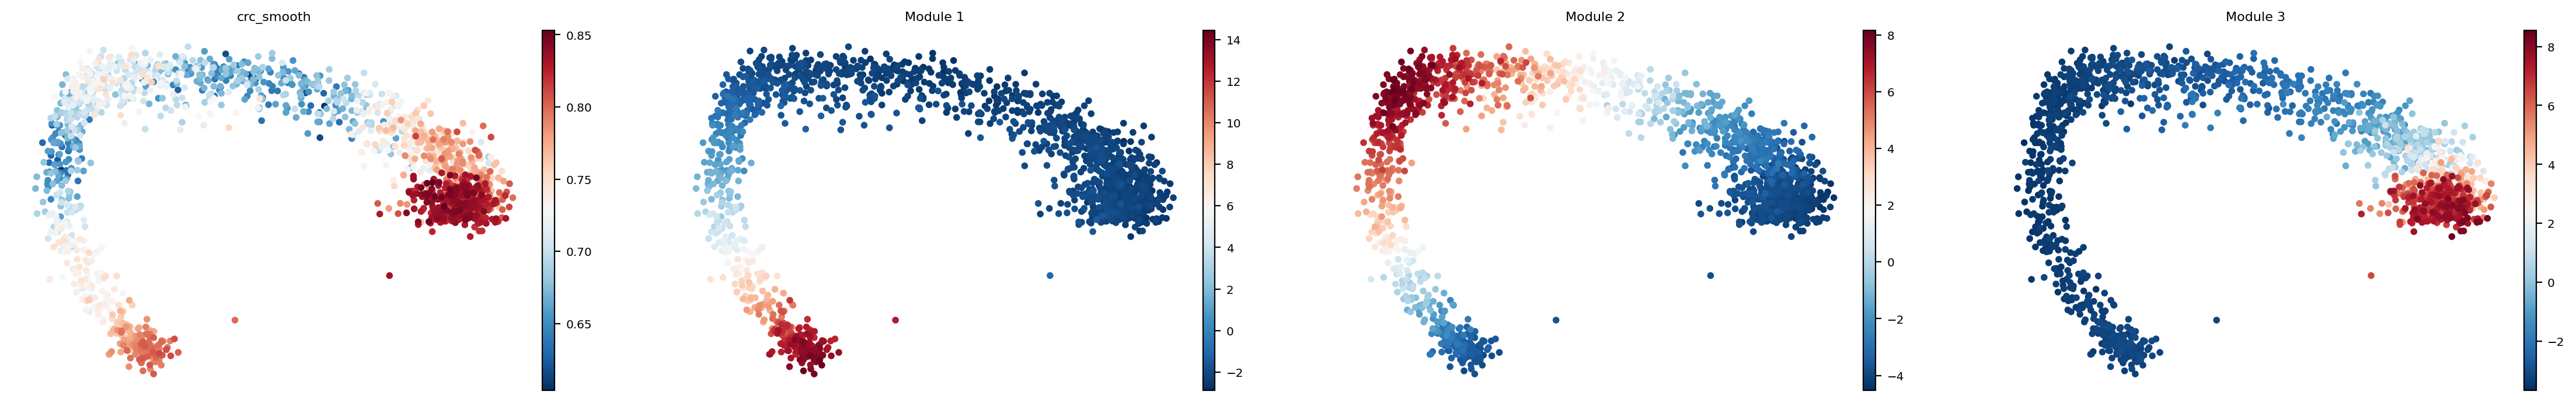

In [158]:
adata.obs['crc_smooth'] = crc_smooth
module_scores = hs.calculate_module_scores()
module_cols = ['crc_smooth']

for c in [1,2,3]:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

fig = sc.pl.pca(adata, color=module_cols, frameon=False, return_fig=True)
fig.savefig(figure_path+f'hotspot_module_score.png',dpi=600,bbox_inches='tight')

In [159]:
g_eig = [0]*path_Fisher_hs.shape[0]
for i in range(path_Fisher_hs.shape[0]):
    g_eig[i] = np.linalg.eigh(path_Fisher_hs[i])

gij_eig = np.array([g_eig[i][0] for i in range(path_Fisher_hs.shape[0])])
gij_eig[np.where(gij_eig<0)] = 0
gij_eig = np.real(gij_eig)

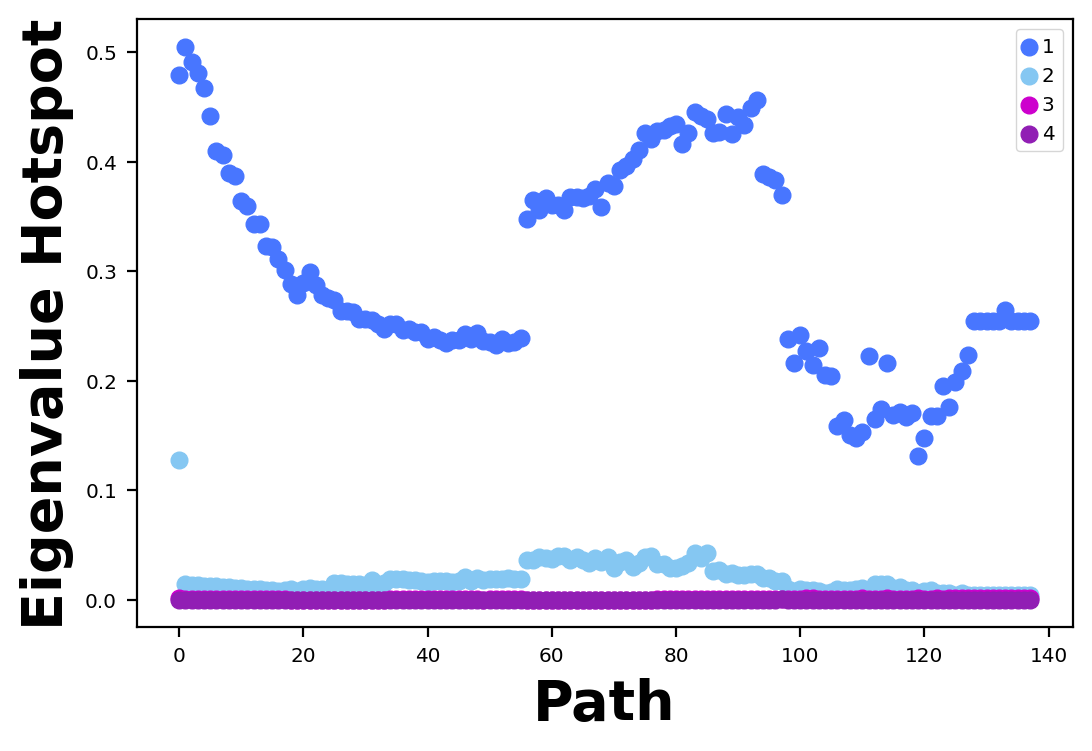

In [160]:
for i in range(path_Fisher_hs.shape[1]):
    plt.scatter(np.array(range(path_Fisher_hs.shape[0])),gij_eig[:,-(i+1)], label=f'{i+1}')
plt.legend()
plt.xlabel('Path',fontsize=20,weight='bold')
plt.ylabel('Eigenvalue Hotspot',fontsize=20,weight='bold')
plt.savefig(figure_path+f'path_eigen_hotspot.png',dpi=600,bbox_inches='tight')
plt.show()